In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

In [2]:
CWD = os.getcwd()
CWD

'/workspace/Brain-Tumor-Classification'

In [21]:
EPOCHS = 30
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [4]:
BASE_DIR = os.path.join(CWD, 'dataset', 'processed', 'Training')
TEST_DIR = os.path.join(CWD, 'dataset', 'processed', 'Testing')

In [5]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(BASE_DIR)]
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [38]:
def prepare_dataset(BASE_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    remain_ds = train_full.skip(num_train_batches)
    valid_ds = remain_ds.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

In [7]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = tf.keras.utils.image_dataset_from_directory(
    directory=BASE_DIR,        
    labels='inferred',         
    label_mode='categorical',  
    class_names=classes,       
    seed=42,                   
    batch_size=32,             
    image_size=(256, 256)      
 )

Found 5712 files belonging to 4 classes.


2024-10-27 13:49:42.764957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22289 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a1:00.0, compute capability: 8.9
2024-10-27 13:49:43.185927: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    labels='inferred',
    label_mode = 'categorical',
    class_names=classes,
    seed=42,
    batch_size=32,
    image_size=(256,256)
)

Found 1311 files belonging to 4 classes.


In [9]:
train_full = train_full.prefetch(tf.data.AUTOTUNE)

In [10]:
# Counting number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.70)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches

# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27


In [11]:
# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches)
# test_ds = remain_ds.skip(num_valid_test_batches//2)

In [12]:
train_ds = train_ds.shuffle(buffer_size=3)

In [13]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [14]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [15]:
def build_model_not_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

In [16]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    start = time.time()

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
    )

    end = time.time()

    # Counting trianing time
    training_time = end - start
    print(f"Training completed in {training_time:.2f} seconds.")

    return model, history, training_time

In [17]:
def plot(model, history, test_ds):
    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2)
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2)
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return history, test_loss, test_acc, test_f1score


In [18]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time):
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score[0])
    result_dict['Training Time'].append(training_time)

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': [],
    'Training Time': []
}

# Prepare training dataset

In [39]:
train_ds_224, valid_ds_224, test_ds_224 = prepare_dataset(BASE_DIR, 224, 32)
train_ds_300, valid_ds_300, test_ds_300 = prepare_dataset(BASE_DIR, 300, 24)
train_ds_380, valid_ds_380, test_ds_380 = prepare_dataset(BASE_DIR, 380, 8)

Found 5712 files belonging to 4 classes.
Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 238
 Target : 
-----------------------------------
Number of  Train  batches : 166
Number of Validation batches : 36
Number of Test batches : 36
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 714
 Target : 
-----------------------------------
Number of  Train  batches : 499
Number of Validation batches : 107
Number of Test batches : 107
Found 1311 files belonging to 4 classes.


# Model Training

## Standard

### EfficientNetV2B0

#### trainable first25

Epoch 1/30


2024-10-27 14:01:44.515443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7732 - f1_score: 0.7677

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 35s 81ms/step - loss: 0.6081 - accuracy: 0.7732 - f1_score: 0.7677 - val_loss: 0.3418 - val_accuracy: 0.8756 - val_f1_score: 0.8642 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 8s 67ms/step - loss: 0.2501 - accuracy: 0.9160 - f1_score: 0.9138 - val_loss: 0.1186 - val_accuracy: 0.9574 - val_f1_score: 0.9552 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 9s 70ms/step - loss: 0.1231 - accuracy: 0.9578 - f1_score: 0.9566 - val_loss: 0.0864 - val_accuracy: 0.9696 - val_f1_score: 0.9682 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 9s 69ms/step - loss: 0.0614 - accuracy: 0.9797 - f1_score: 0.9793 - val_loss: 0.0653 - val_accuracy: 0.9796 - val_f1_score: 0.9785 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 8s 60ms/step - loss: 0.0390 - accuracy: 0.9875 - f1_score: 0.9871 - val_loss: 0.1315 - val_accuracy: 0.9638 - val_f1_score: 0.9607 - lr: 1.0000e-04


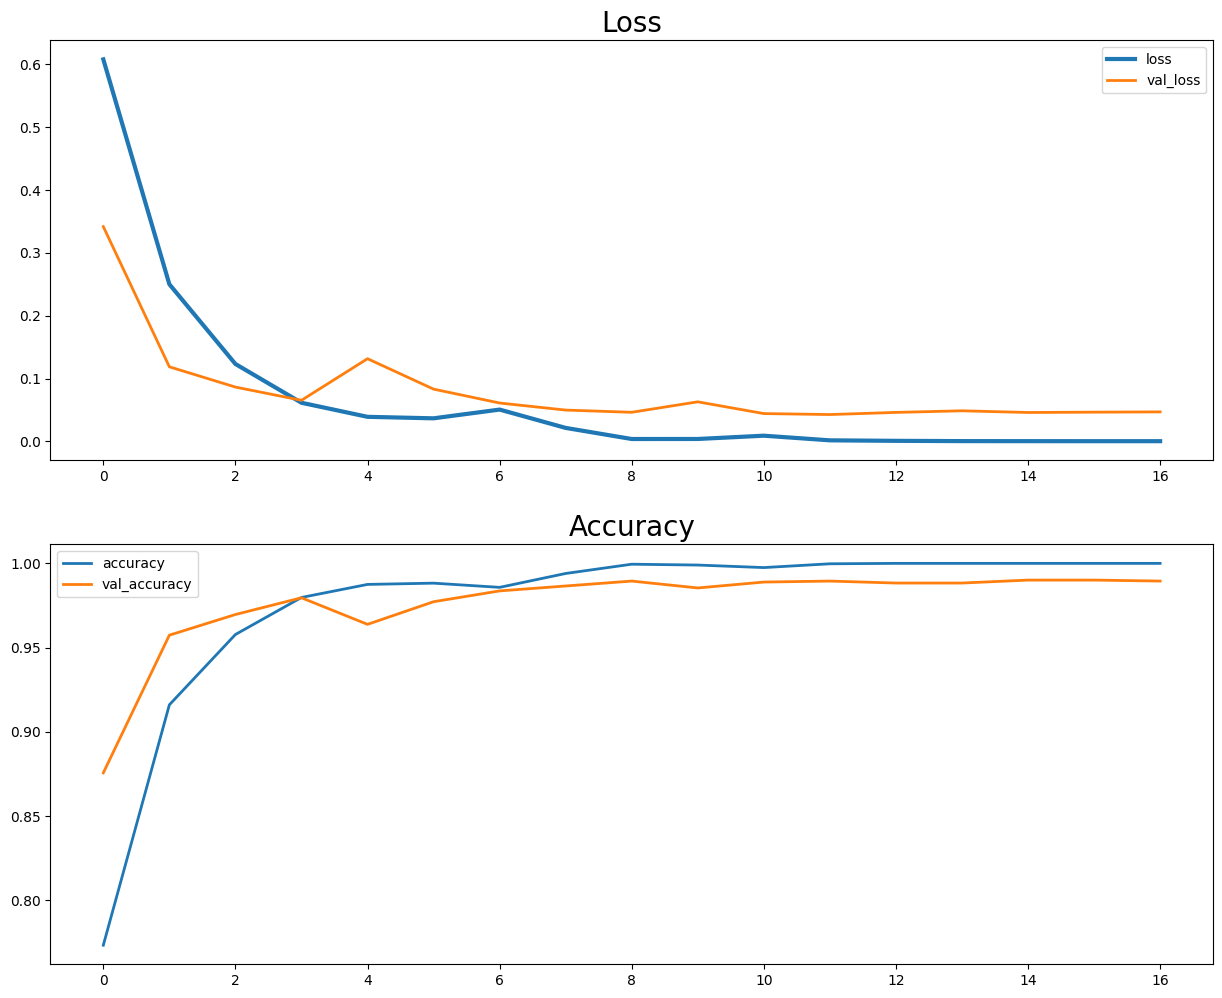

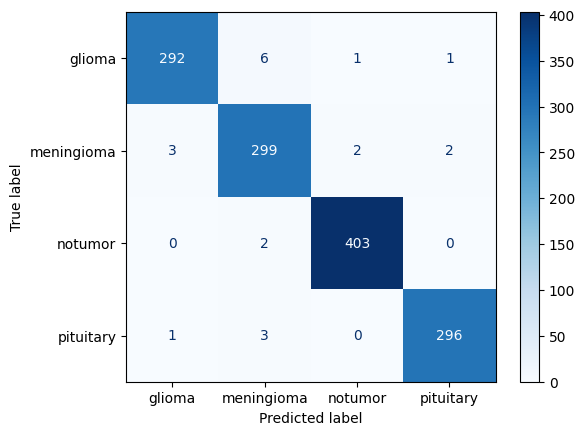

Classification Report
              precision    recall  f1-score   support

           0    0.98649   0.97333   0.97987       300
           1    0.96452   0.97712   0.97078       306
           2    0.99261   0.99506   0.99383       405
           3    0.98997   0.98667   0.98831       300

    accuracy                        0.98398      1311
   macro avg    0.98340   0.98305   0.98320      1311
weighted avg    0.98405   0.98398   0.98399      1311



In [28]:
model_name = 'efficientnetv2b0_standart_trainable_first25'
input_shape = (224,224,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25, training_time = train(std_b0_tf25, model_name, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)
history_std_b0_tf25, test_loss, test_acc, test_f1score = plot(std_b0_tf25, history_std_b0_tf25, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 14:04:34.303224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


124/125 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.7291 - f1_score: 0.7186

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 18s 55ms/step - loss: 0.6746 - accuracy: 0.7305 - f1_score: 0.7198 - val_loss: 0.3050 - val_accuracy: 0.8943 - val_f1_score: 0.8926 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 6s 44ms/step - loss: 0.2577 - accuracy: 0.9080 - f1_score: 0.9053 - val_loss: 0.1843 - val_accuracy: 0.9363 - val_f1_score: 0.9326 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 5s 43ms/step - loss: 0.1589 - accuracy: 0.9475 - f1_score: 0.9461 - val_loss: 0.1556 - val_accuracy: 0.9527 - val_f1_score: 0.9507 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 6s 48ms/step - loss: 0.0663 - accuracy: 0.9765 - f1_score: 0.9758 - val_loss: 0.1255 - val_accuracy: 0.9720 - val_f1_score: 0.9707 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.0484 - accuracy: 0.9845 - f1_score: 0.9841 - val_loss: 0.4197 - val_accuracy: 0.8902 - val_f1_score: 0.8870 - lr: 1.0000e-04


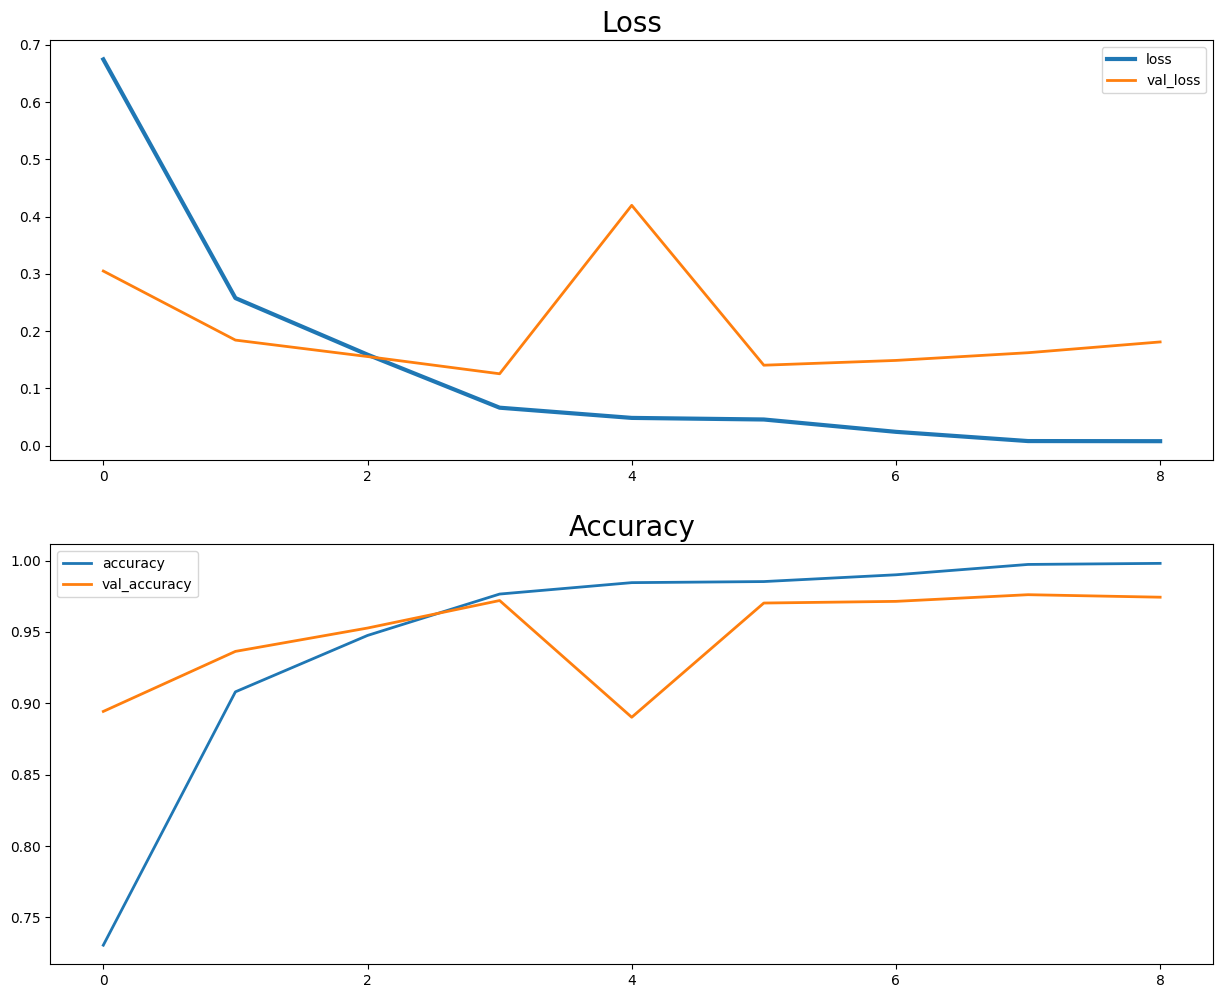

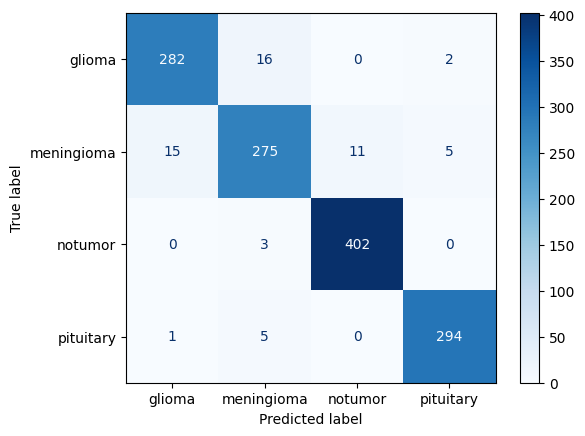

Classification Report
              precision    recall  f1-score   support

           0    0.94631   0.94000   0.94314       300
           1    0.91973   0.89869   0.90909       306
           2    0.97337   0.99259   0.98289       405
           3    0.97674   0.98000   0.97837       300

    accuracy                        0.95576      1311
   macro avg    0.95404   0.95282   0.95337      1311
weighted avg    0.95543   0.95576   0.95553      1311



In [29]:
model_name = 'efficientnetv2b0_standart_trainable_last25'
input_shape = (224,224,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25, training_time = train(std_b0_tl25, model_name, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)
history_std_b0_tl25, test_loss, test_acc, test_f1score = plot(std_b0_tl25, history_std_b0_tl25, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

Epoch 1/30
124/125 [============================>.] - ETA: 0s - loss: 0.9439 - accuracy: 0.6195 - f1_score: 0.6044

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 11s 46ms/step - loss: 0.9418 - accuracy: 0.6208 - f1_score: 0.6060 - val_loss: 0.5748 - val_accuracy: 0.8032 - val_f1_score: 0.7799 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 4s 33ms/step - loss: 0.5590 - accuracy: 0.7958 - f1_score: 0.7874 - val_loss: 0.3892 - val_accuracy: 0.8616 - val_f1_score: 0.8493 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 4s 33ms/step - loss: 0.4410 - accuracy: 0.8350 - f1_score: 0.8293 - val_loss: 0.3258 - val_accuracy: 0.8814 - val_f1_score: 0.8730 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 4s 34ms/step - loss: 0.3896 - accuracy: 0.8610 - f1_score: 0.8562 - val_loss: 0.2918 - val_accuracy: 0.8890 - val_f1_score: 0.8807 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 4s 34ms/step - loss: 0.3494 - accuracy: 0.8720 - f1_score: 0.8669 - val_loss: 0.2706 - val_accuracy: 0.9019 - val_f1_score: 0.8936 - lr: 1.0000e-04


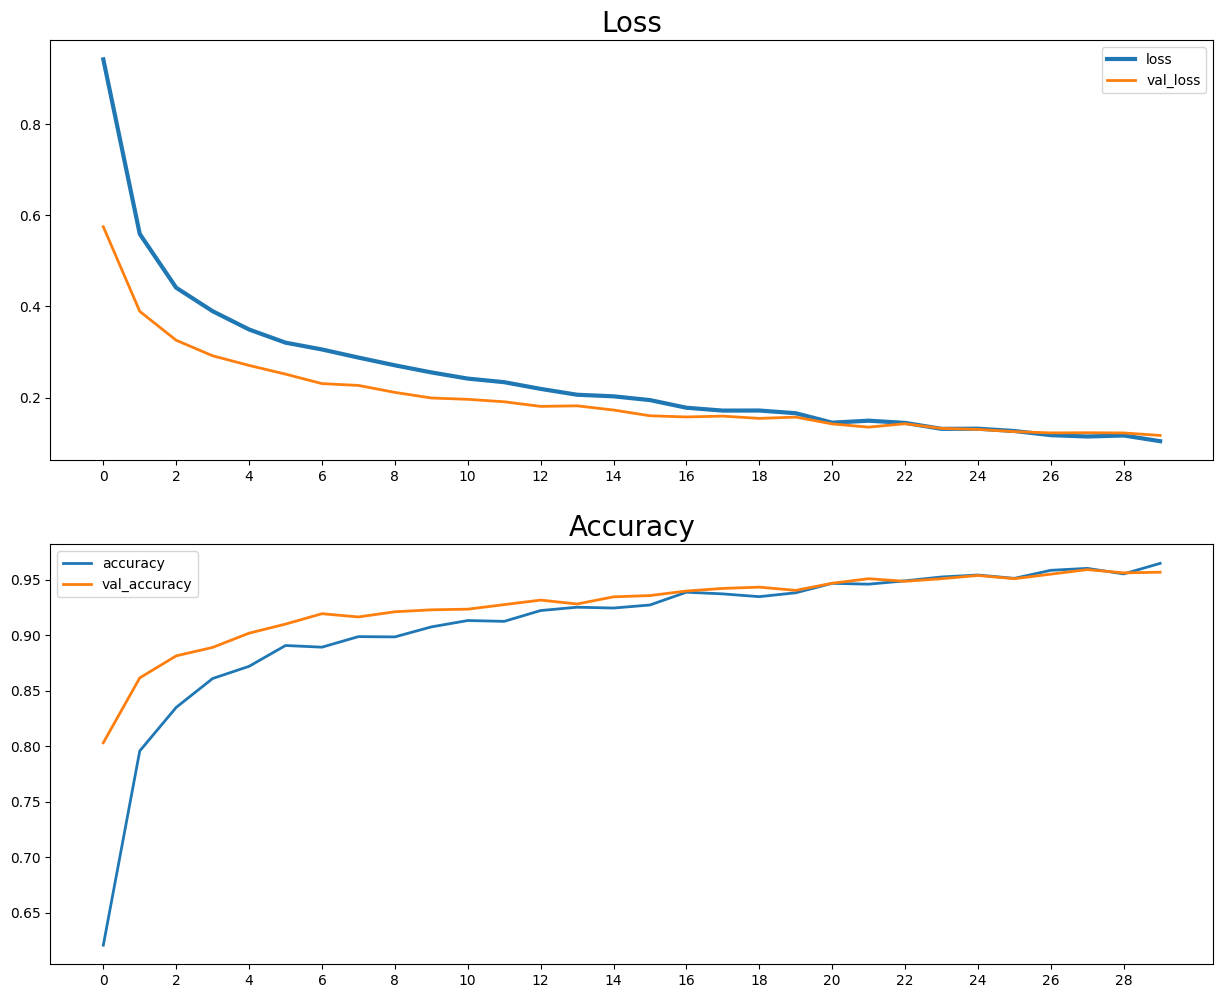

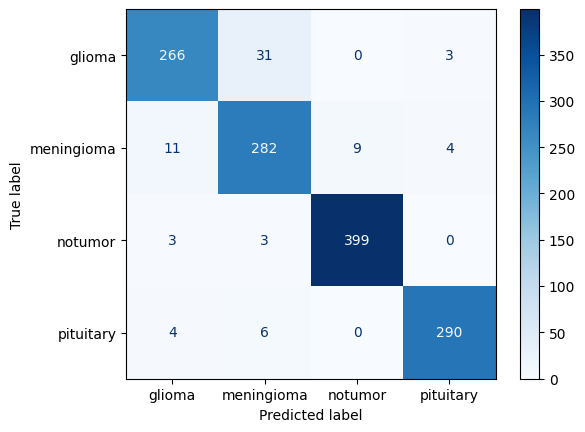

Classification Report
              precision    recall  f1-score   support

           0    0.93662   0.88667   0.91096       300
           1    0.87578   0.92157   0.89809       306
           2    0.97794   0.98519   0.98155       405
           3    0.97643   0.96667   0.97152       300

    accuracy                        0.94355      1311
   macro avg    0.94169   0.94002   0.94053      1311
weighted avg    0.94429   0.94355   0.94362      1311



In [30]:
model_name = 'efficientnetv2b0_standart_not_trainable'
input_shape = (224,224,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt, training_time = train(std_b0_nt, model_name, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)
history_std_b0_nt, test_loss, test_acc, test_f1score = plot(std_b0_nt, history_std_b0_nt, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

### EfficientNetV2B3

#### trainable first25

52606240/52606240 [==============================] - 2s 0us/step
Epoch 1/30


2024-10-27 14:08:47.902987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.8083 - f1_score: 0.8031

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 61s 159ms/step - loss: 0.5221 - accuracy: 0.8083 - f1_score: 0.8031 - val_loss: 0.1909 - val_accuracy: 0.9393 - val_f1_score: 0.9367 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 17s 138ms/step - loss: 0.1945 - accuracy: 0.9348 - f1_score: 0.9332 - val_loss: 0.0761 - val_accuracy: 0.9772 - val_f1_score: 0.9764 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 15s 121ms/step - loss: 0.0685 - accuracy: 0.9805 - f1_score: 0.9800 - val_loss: 0.1015 - val_accuracy: 0.9714 - val_f1_score: 0.9702 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 15s 123ms/step - loss: 0.0422 - accuracy: 0.9865 - f1_score: 0.9863 - val_loss: 0.0731 - val_accuracy: 0.9737 - val_f1_score: 0.9726 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 17s 137ms/step - loss: 0.0278 - accuracy: 0.9920 - f1_score: 0.9918 - val_loss: 0.0357 - val_accuracy: 0.9889 - val_f1_score: 0.9883 - lr: 1.

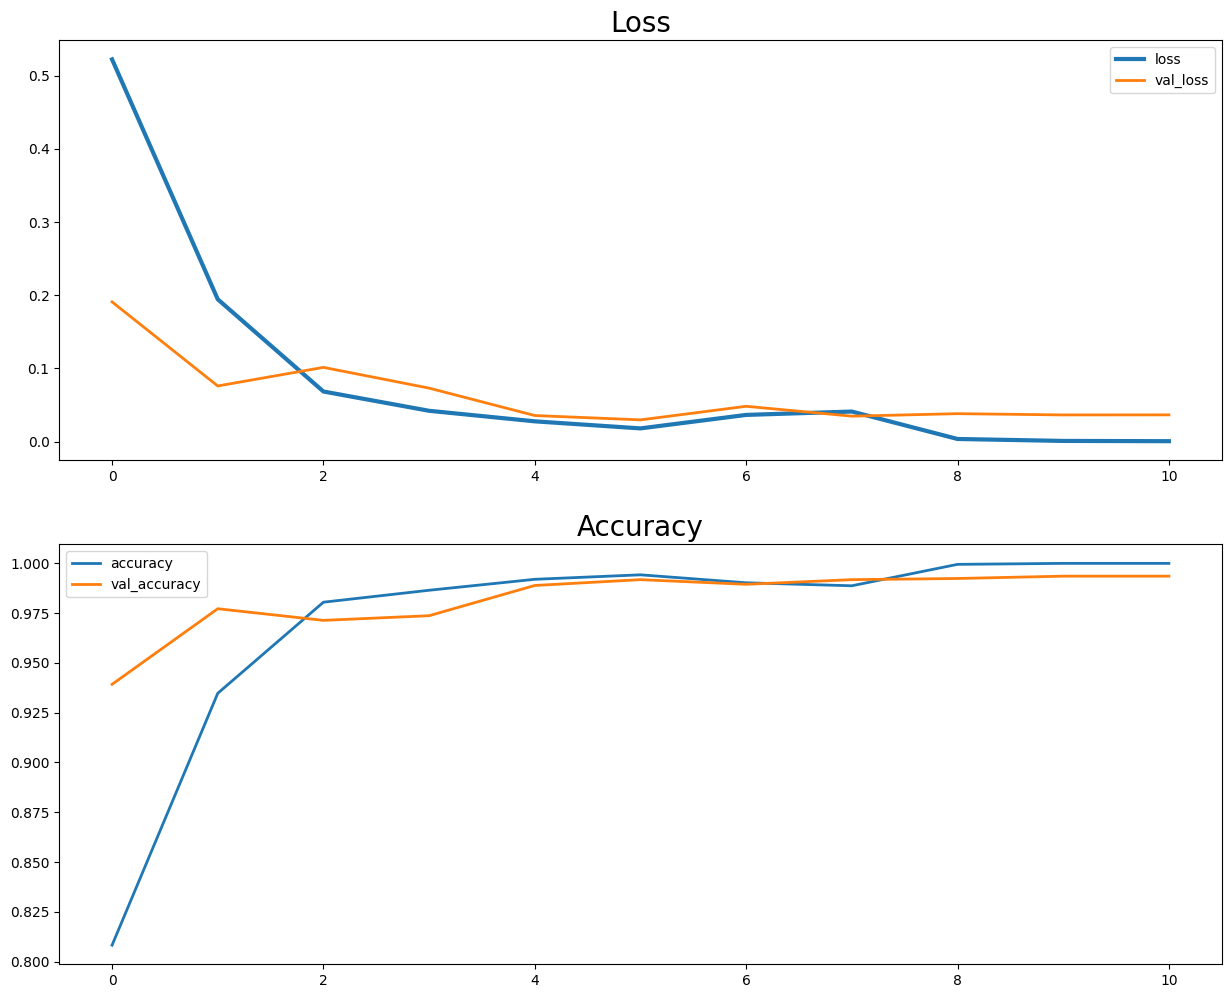

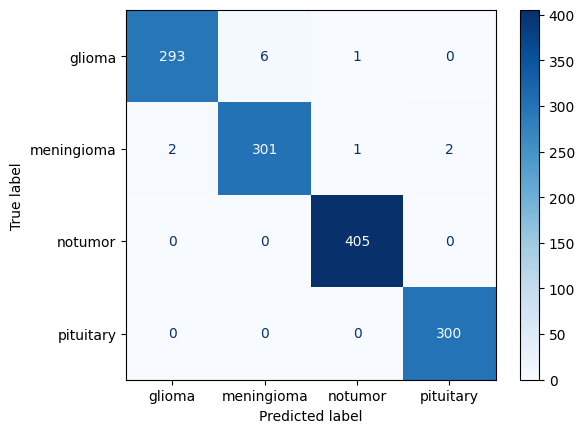

Classification Report
              precision    recall  f1-score   support

           0    0.99322   0.97667   0.98487       300
           1    0.98046   0.98366   0.98206       306
           2    0.99509   1.00000   0.99754       405
           3    0.99338   1.00000   0.99668       300

    accuracy                        0.99085      1311
   macro avg    0.99053   0.99008   0.99029      1311
weighted avg    0.99085   0.99085   0.99083      1311



In [31]:
model_name = 'efficientnetv2b3_standart_trainable_first25'
input_shape = (300,300,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25, training_time = train(std_b3_tf25, model_name, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tf25, test_loss, test_acc, test_f1score = plot(std_b3_tf25, history_std_b3_tf25, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 14:12:42.661875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.7920 - f1_score: 0.7844

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 30s 102ms/step - loss: 0.5378 - accuracy: 0.7920 - f1_score: 0.7844 - val_loss: 0.2136 - val_accuracy: 0.9241 - val_f1_score: 0.9182 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 11s 84ms/step - loss: 0.1847 - accuracy: 0.9375 - f1_score: 0.9358 - val_loss: 0.1230 - val_accuracy: 0.9591 - val_f1_score: 0.9571 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 10s 81ms/step - loss: 0.0882 - accuracy: 0.9670 - f1_score: 0.9659 - val_loss: 0.1047 - val_accuracy: 0.9603 - val_f1_score: 0.9578 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 10s 83ms/step - loss: 0.0326 - accuracy: 0.9895 - f1_score: 0.9892 - val_loss: 0.1253 - val_accuracy: 0.9702 - val_f1_score: 0.9682 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 10s 82ms/step - loss: 0.0203 - accuracy: 0.9942 - f1_score: 0.9940 - val_loss: 0.1110 - val_accuracy: 0.9766 - val_f1_score: 0.9750 - lr: 1.0000

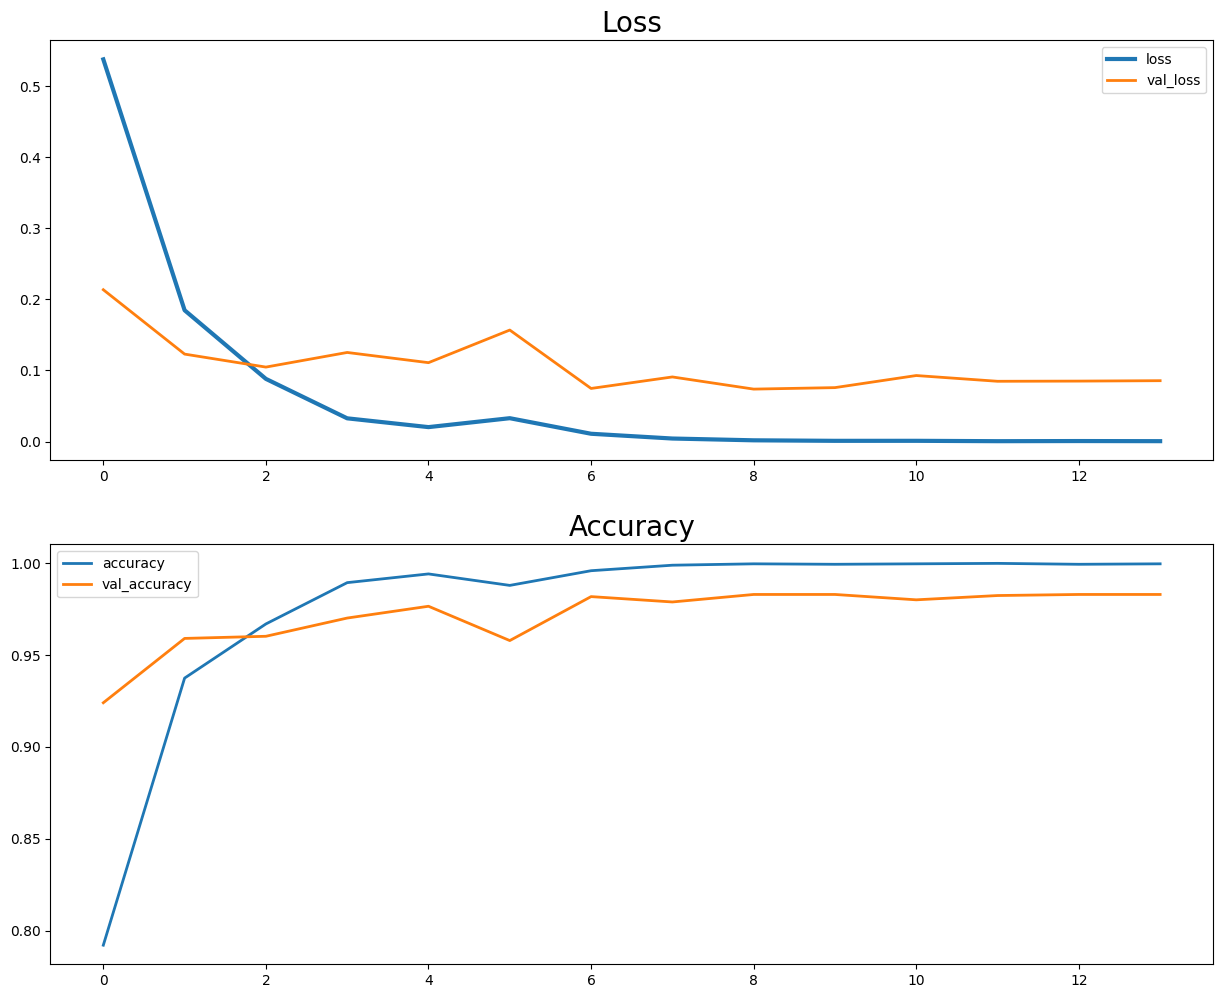

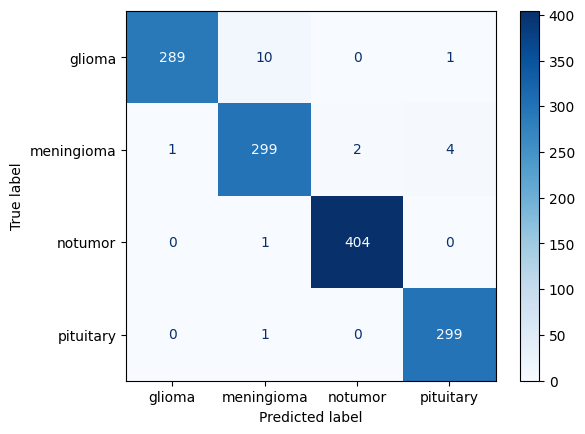

Classification Report
              precision    recall  f1-score   support

           0    0.99655   0.96333   0.97966       300
           1    0.96141   0.97712   0.96921       306
           2    0.99507   0.99753   0.99630       405
           3    0.98355   0.99667   0.99007       300

    accuracy                        0.98474      1311
   macro avg    0.98415   0.98366   0.98381      1311
weighted avg    0.98492   0.98474   0.98474      1311



In [32]:
model_name = 'efficientnetv2b3_standart_trainable_last25'
input_shape = (300,300,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25, training_time = train(std_b3_tl25, model_name, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tl25, test_loss, test_acc, test_f1score = plot(std_b3_tl25, history_std_b3_tl25, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.6518 - f1_score: 0.6380

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 20s 99ms/step - loss: 0.9006 - accuracy: 0.6518 - f1_score: 0.6380 - val_loss: 0.5393 - val_accuracy: 0.8049 - val_f1_score: 0.7836 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 9s 75ms/step - loss: 0.5265 - accuracy: 0.8100 - f1_score: 0.8029 - val_loss: 0.3913 - val_accuracy: 0.8557 - val_f1_score: 0.8447 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 9s 76ms/step - loss: 0.4218 - accuracy: 0.8438 - f1_score: 0.8386 - val_loss: 0.3262 - val_accuracy: 0.8727 - val_f1_score: 0.8625 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 10s 80ms/step - loss: 0.3663 - accuracy: 0.8675 - f1_score: 0.8632 - val_loss: 0.2817 - val_accuracy: 0.8925 - val_f1_score: 0.8857 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 9s 71ms/step - loss: 0.3322 - accuracy: 0.8802 - f1_score: 0.8763 - val_loss: 0.2629 - val_accuracy: 0.9013 - val_f1_score: 0.8949 - lr: 1.0000e-04

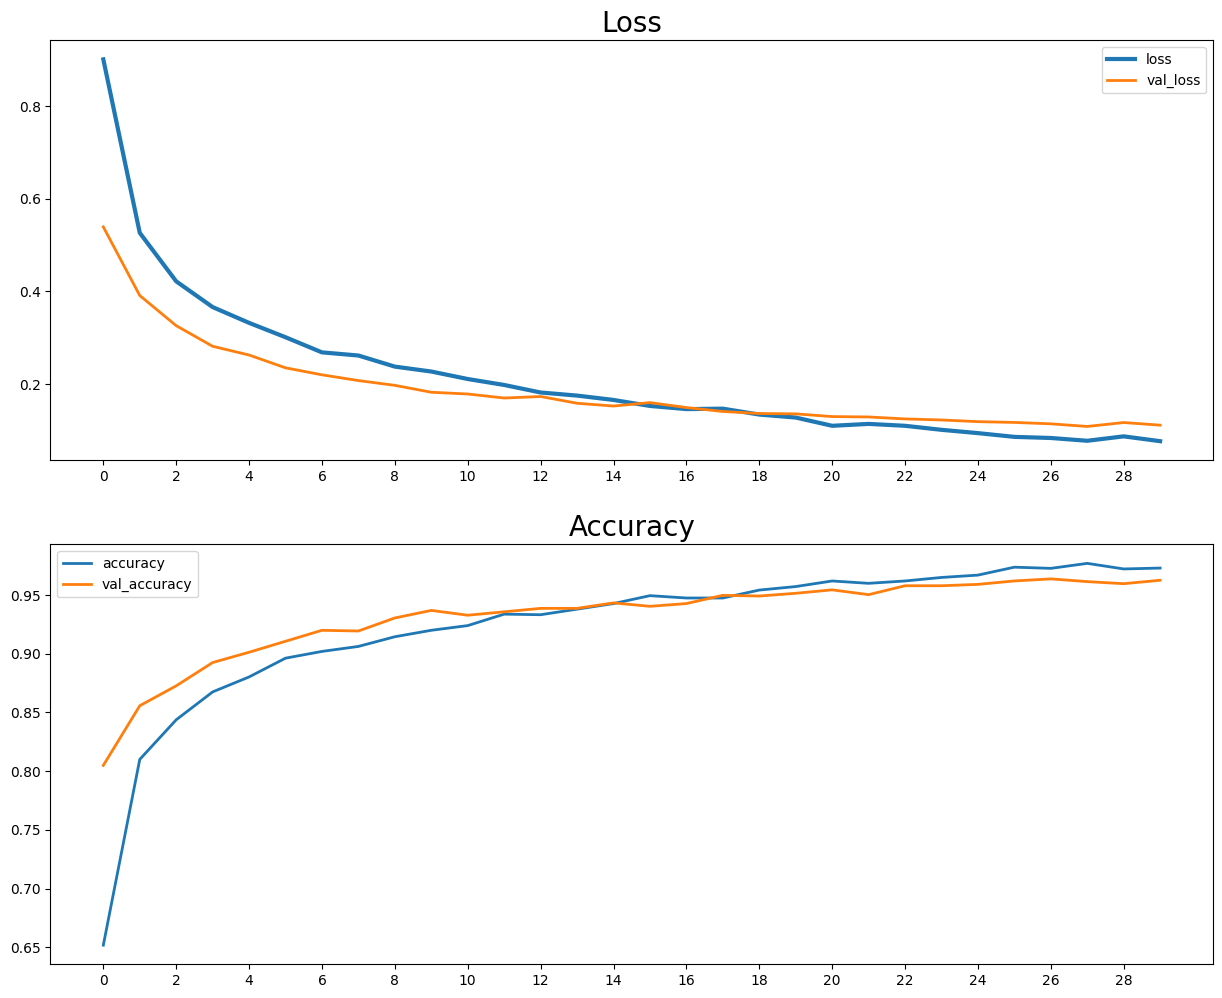

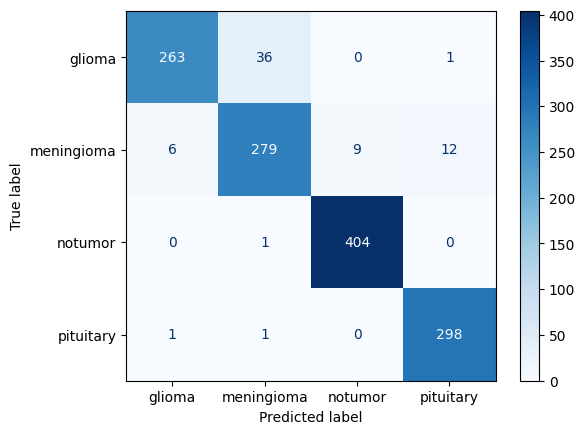

Classification Report
              precision    recall  f1-score   support

           0    0.97407   0.87667   0.92281       300
           1    0.88013   0.91176   0.89567       306
           2    0.97821   0.99753   0.98778       405
           3    0.95820   0.99333   0.97545       300

    accuracy                        0.94889      1311
   macro avg    0.94765   0.94482   0.94542      1311
weighted avg    0.94979   0.94889   0.94859      1311



In [33]:
model_name = 'efficientnetv2b3_standart_not_trainable'
input_shape = (300,300,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt, training_time = train(std_b3_nt, model_name, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)
history_std_b3_nt, test_loss, test_acc, test_f1score = plot(std_b3_nt, history_std_b3_nt, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

### EfficientNetV2M

#### trainable first25

Epoch 1/30


2024-10-27 14:31:49.208431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7936 - f1_score: 0.7874

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 159s 165ms/step - loss: 0.5610 - accuracy: 0.7936 - f1_score: 0.7874 - val_loss: 0.2643 - val_accuracy: 0.9198 - val_f1_score: 0.9170 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 78s 157ms/step - loss: 0.1858 - accuracy: 0.9459 - f1_score: 0.9447 - val_loss: 0.1772 - val_accuracy: 0.9442 - val_f1_score: 0.9429 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 80s 160ms/step - loss: 0.0964 - accuracy: 0.9734 - f1_score: 0.9729 - val_loss: 0.1143 - val_accuracy: 0.9674 - val_f1_score: 0.9661 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 77s 155ms/step - loss: 0.1141 - accuracy: 0.9627 - f1_score: 0.9620 - val_loss: 0.5297 - val_accuracy: 0.8436 - val_f1_score: 0.8332 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 77s 154ms/step - loss: 0.0615 - accuracy: 0.9802 - f1_score: 0.9797 - val_loss: 0.1242 - val_accuracy: 0.9645 - val_f1_score: 0.9637 - lr: 1

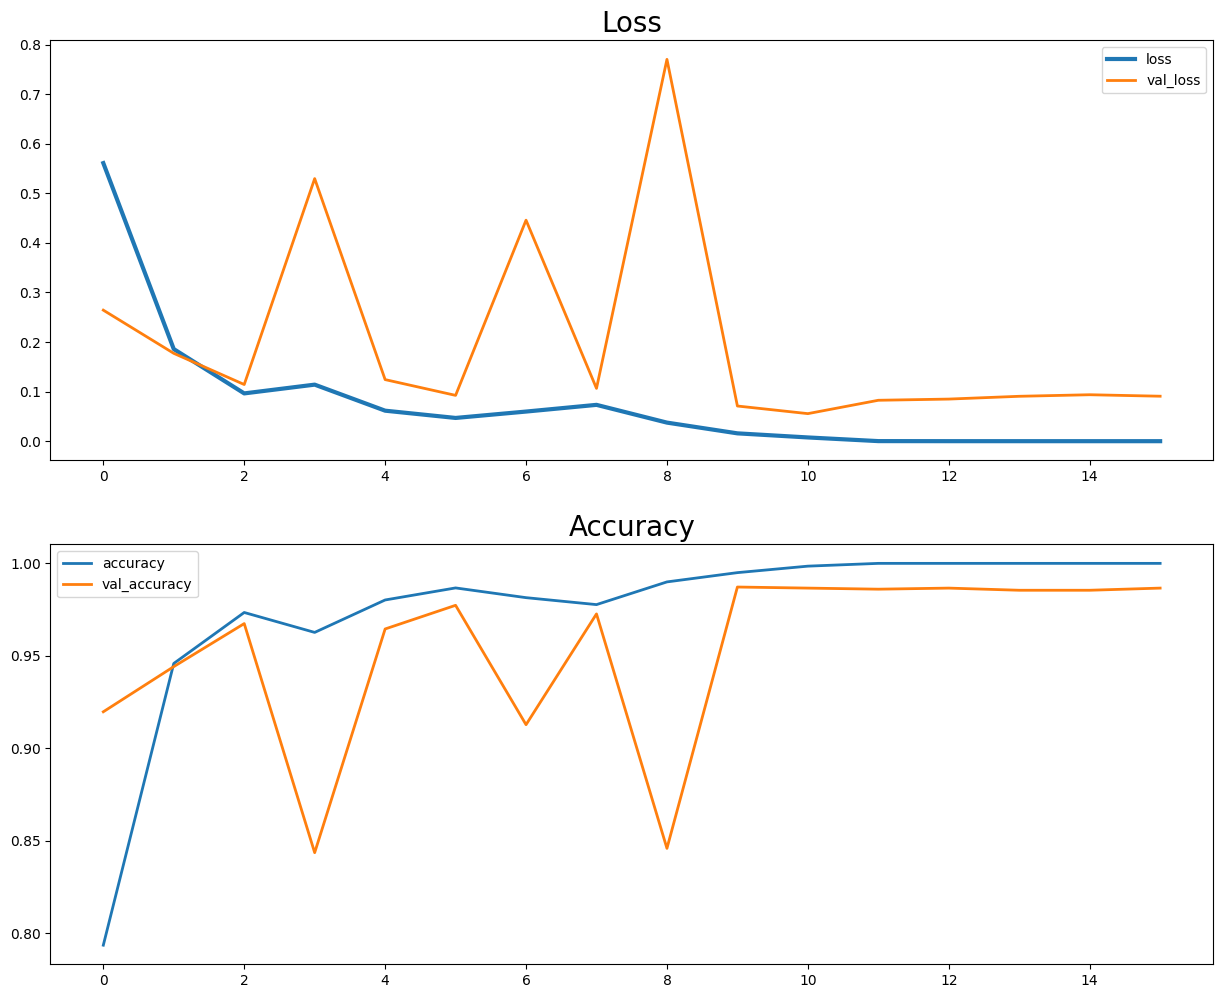

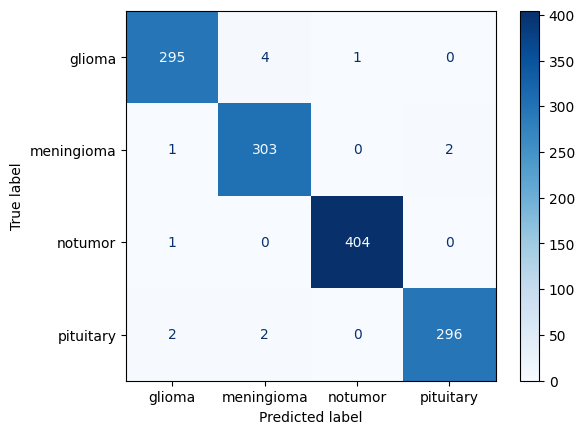

Classification Report
              precision    recall  f1-score   support

           0    0.98662   0.98333   0.98497       300
           1    0.98058   0.99020   0.98537       306
           2    0.99753   0.99753   0.99753       405
           3    0.99329   0.98667   0.98997       300

    accuracy                        0.99008      1311
   macro avg    0.98951   0.98943   0.98946      1311
weighted avg    0.99011   0.99008   0.99009      1311



In [40]:
model_name = 'efficientnetv2m_standart_trainable_first25'
input_shape = (380,380,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25, training_time = train(std_m_tf25, model_name, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)
history_std_m_tf25, test_loss, test_acc, test_f1score = plot(std_m_tf25, history_std_m_tf25, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 14:54:03.742009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.8427 - f1_score: 0.8387

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 86s 109ms/step - loss: 0.4421 - accuracy: 0.8427 - f1_score: 0.8387 - val_loss: 0.2698 - val_accuracy: 0.9163 - val_f1_score: 0.9135 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 49s 98ms/step - loss: 0.1529 - accuracy: 0.9504 - f1_score: 0.9492 - val_loss: 0.1063 - val_accuracy: 0.9616 - val_f1_score: 0.9590 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 47s 94ms/step - loss: 0.1065 - accuracy: 0.9684 - f1_score: 0.9676 - val_loss: 0.4218 - val_accuracy: 0.8680 - val_f1_score: 0.8661 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 49s 98ms/step - loss: 0.0662 - accuracy: 0.9795 - f1_score: 0.9788 - val_loss: 0.1296 - val_accuracy: 0.9640 - val_f1_score: 0.9618 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 47s 93ms/step - loss: 0.0604 - accuracy: 0.9827 - f1_score: 0.9824 - val_loss: 0.1782 - val_accuracy: 0.9488 - val_f1_score: 0.9489 - lr: 1.0000

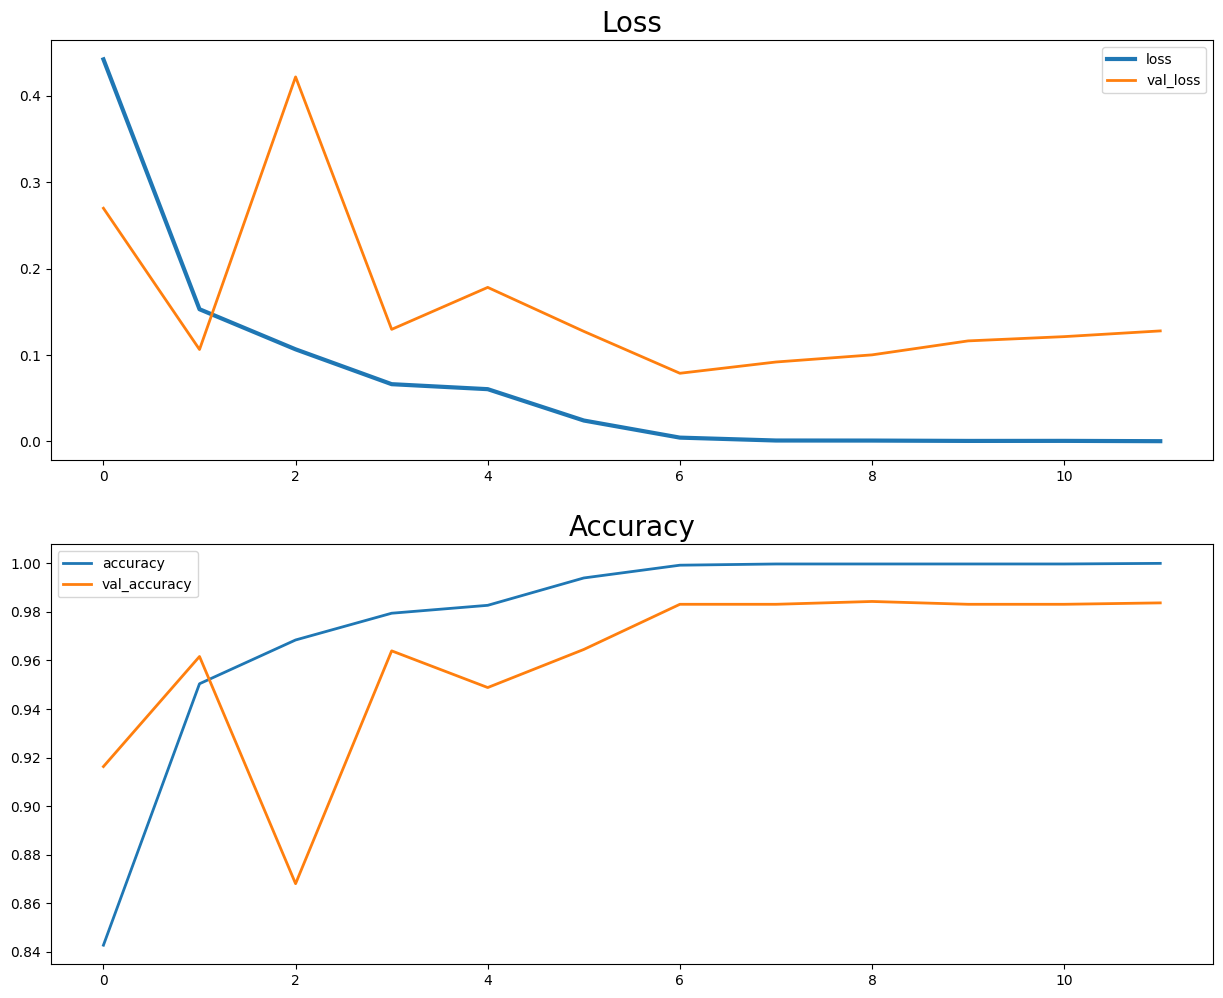

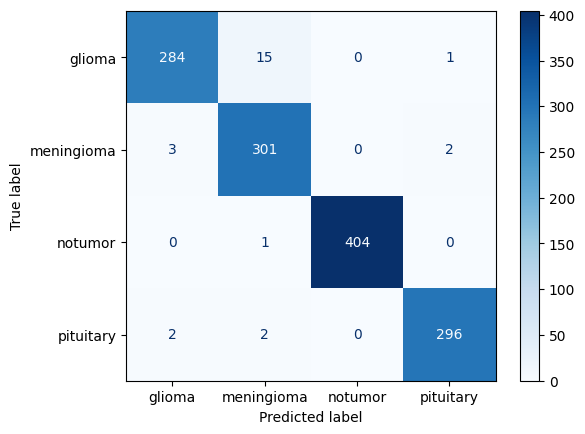

Classification Report
              precision    recall  f1-score   support

           0    0.98270   0.94667   0.96435       300
           1    0.94357   0.98366   0.96320       306
           2    1.00000   0.99753   0.99876       405
           3    0.98997   0.98667   0.98831       300

    accuracy                        0.98017      1311
   macro avg    0.97906   0.97863   0.97866      1311
weighted avg    0.98057   0.98017   0.98020      1311



In [41]:
model_name = 'efficientnetv2m_standart_trainable_last25'
input_shape = (380,380,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25, training_time = train(std_m_tl25, model_name, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)
history_std_m_tl25, test_loss, test_acc, test_f1score = plot(std_m_tl25, history_std_m_tl25, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

In [42]:
model_name = 'efficientnetv2m_standart_not_trainable'
input_shape = (380,380,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt, training_time = train(std_m_nt, model_name, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)
history_std_m_nt, test_loss, test_acc, test_f1score = plot(std_m_nt, history_std_m_nt, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

Epoch 1/30
499/499 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.6791 - f1_score: 0.6642

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 49s 71ms/step - loss: 0.8013 - accuracy: 0.6791 - f1_score: 0.6642 - val_loss: 0.4873 - val_accuracy: 0.8169 - val_f1_score: 0.8071 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 31s 63ms/step - loss: 0.4939 - accuracy: 0.8044 - f1_score: 0.7970 - val_loss: 0.3878 - val_accuracy: 0.8500 - val_f1_score: 0.8415 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 33s 66ms/step - loss: 0.4023 - accuracy: 0.8482 - f1_score: 0.8429 - val_loss: 0.3232 - val_accuracy: 0.8750 - val_f1_score: 0.8661 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 32s 65ms/step - loss: 0.3595 - accuracy: 0.8667 - f1_score: 0.8622 - val_loss: 0.3051 - val_accuracy: 0.8837 - val_f1_score: 0.8758 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 32s 64ms/step - loss: 0.3215 - accuracy: 0.8778 - f1_score: 0.8736 - val_loss: 0.2799 - val_accuracy: 0.8855 - val_f1_score: 0.8779 - lr: 1.0000e

NameError: name 'test_ds_280' is not defined

1/1 [==============================] - 0s 42ms/step


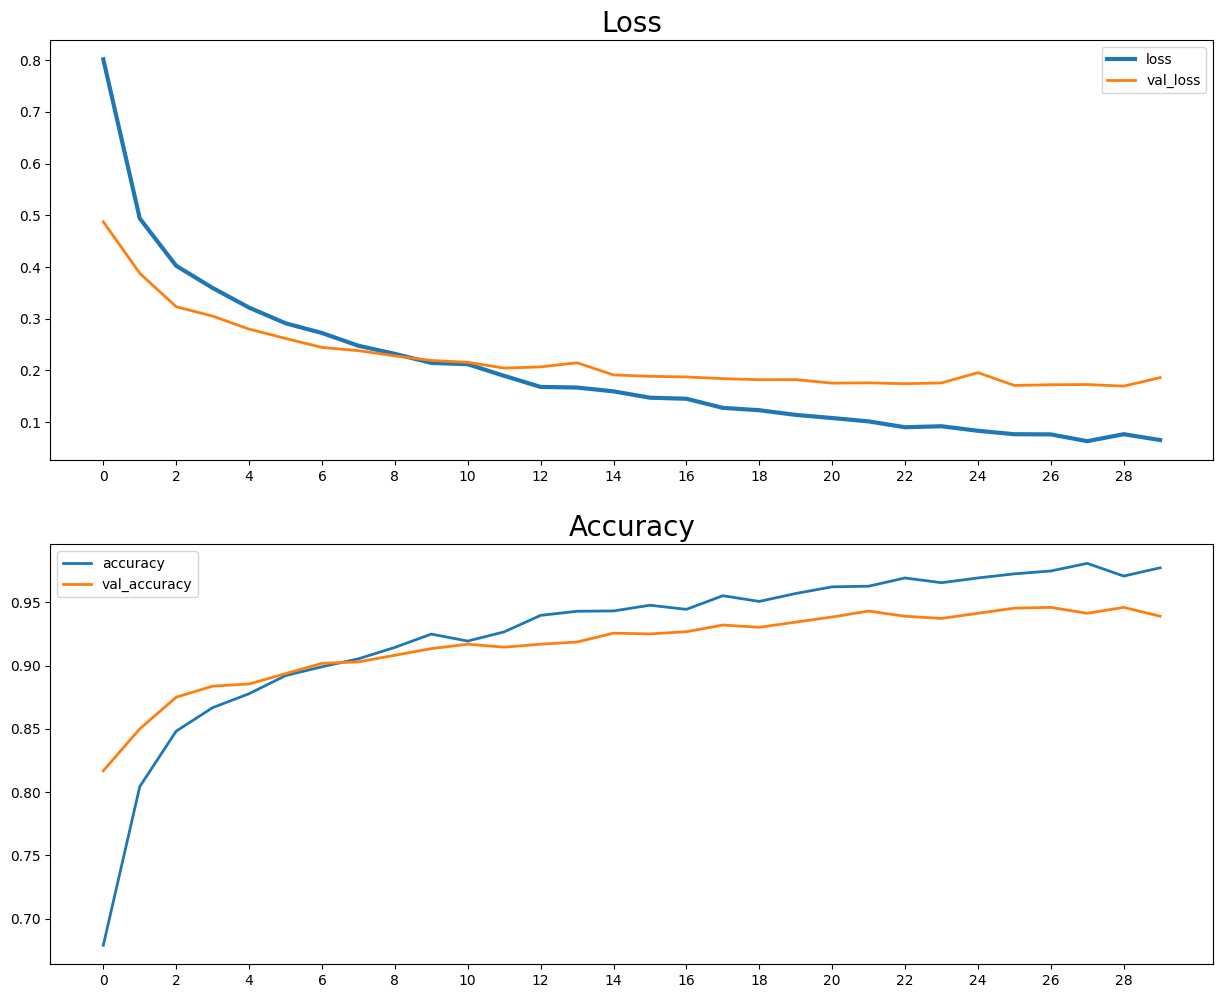

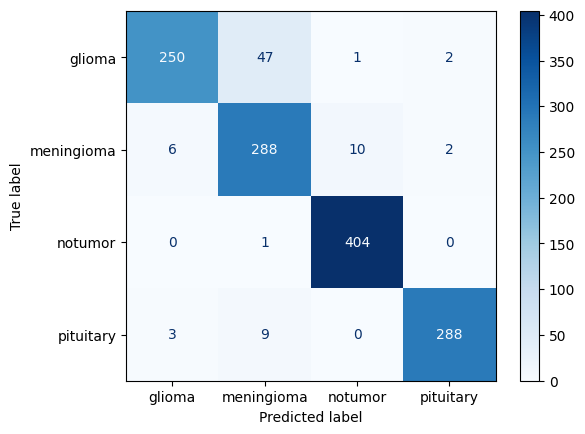

Classification Report
              precision    recall  f1-score   support

           0    0.96525   0.83333   0.89445       300
           1    0.83478   0.94118   0.88479       306
           2    0.97349   0.99753   0.98537       405
           3    0.98630   0.96000   0.97297       300

    accuracy                        0.93822      1311
   macro avg    0.93996   0.93301   0.93440      1311
weighted avg    0.94216   0.93822   0.93825      1311



In [43]:
history_std_m_nt, test_loss, test_acc, test_f1score = plot(std_m_nt, history_std_m_nt, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

## Augmentation

In [44]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15)
])

In [45]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [46]:
train_aug_224 = train_ds_224.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_224 = valid_ds_224.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_224 = train_aug_224.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_224 = valid_aug_224.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
train_aug_300 = train_ds_300.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_300 = valid_ds_300.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_300 = train_aug_300.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_300 = valid_aug_300.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
train_aug_380 = train_ds_380.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_380 = valid_ds_380.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_380 = train_aug_380.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_380 = valid_aug_380.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### EfficientNetV2B0

#### trainable first25

Epoch 1/30


2024-10-27 15:21:25.430258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_17/dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.6675 - f1_score: 0.6584

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 41s 100ms/step - loss: 0.8046 - accuracy: 0.6675 - f1_score: 0.6584 - val_loss: 0.5264 - val_accuracy: 0.8043 - val_f1_score: 0.7938 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 10s 79ms/step - loss: 0.3277 - accuracy: 0.8835 - f1_score: 0.8809 - val_loss: 0.2060 - val_accuracy: 0.9287 - val_f1_score: 0.9255 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 9s 70ms/step - loss: 0.1610 - accuracy: 0.9423 - f1_score: 0.9409 - val_loss: 0.2568 - val_accuracy: 0.9112 - val_f1_score: 0.9114 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 10s 76ms/step - loss: 0.1006 - accuracy: 0.9680 - f1_score: 0.9673 - val_loss: 0.1272 - val_accuracy: 0.9585 - val_f1_score: 0.9568 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 8s 63ms/step - loss: 0.0516 - accuracy: 0.9827 - f1_score: 0.9825 - val_loss: 0.2466 - val_accuracy: 0.9357 - val_f1_score: 0.9321 - lr: 1.0000e-

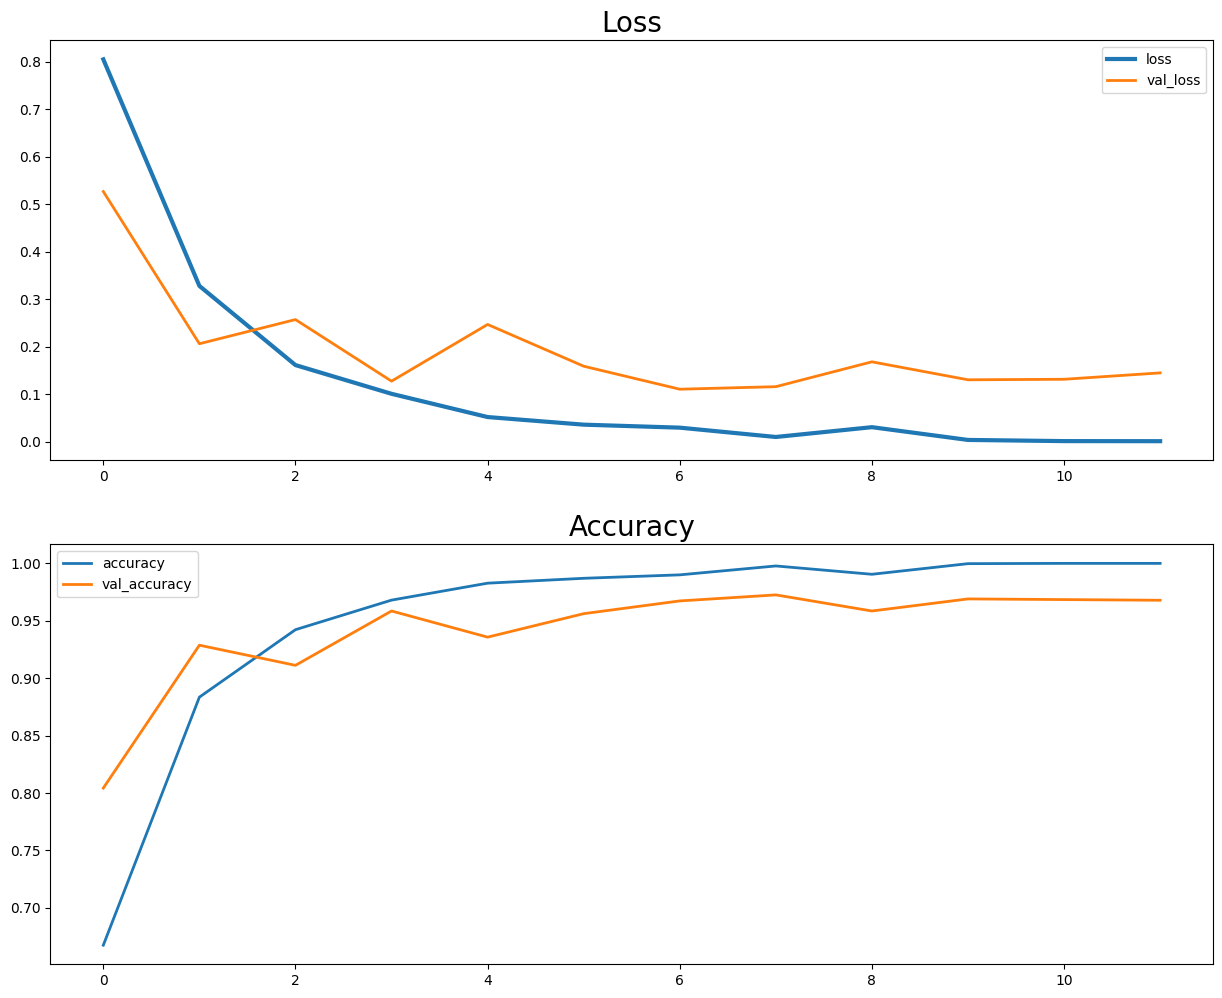

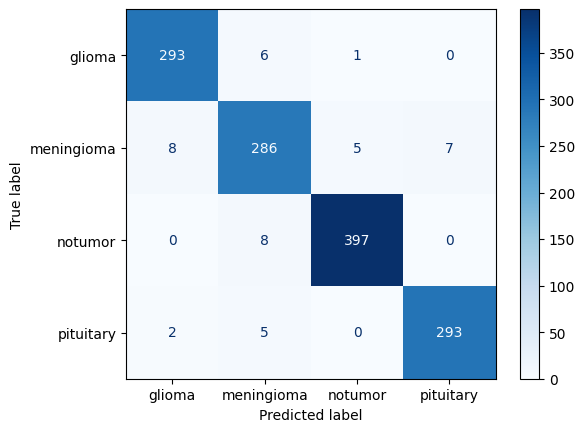

Classification Report
              precision    recall  f1-score   support

           0    0.96700   0.97667   0.97181       300
           1    0.93770   0.93464   0.93617       306
           2    0.98511   0.98025   0.98267       405
           3    0.97667   0.97667   0.97667       300

    accuracy                        0.96796      1311
   macro avg    0.96662   0.96706   0.96683      1311
weighted avg    0.96797   0.96796   0.96796      1311



In [49]:
model_name = 'efficientnetv2b0_augmentation_trainable_first25'
input_shape = (224,224,3)

aug_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tf25, history_aug_b0_tf25, training_time = train(aug_b0_tf25, model_name, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tf25, test_loss, test_acc, test_f1score = plot(aug_b0_tf25, history_aug_b0_tf25, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 15:23:50.249330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.8301 - accuracy: 0.6645 - f1_score: 0.6554

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 20s 68ms/step - loss: 0.8301 - accuracy: 0.6645 - f1_score: 0.6554 - val_loss: 0.3966 - val_accuracy: 0.8633 - val_f1_score: 0.8564 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 6s 50ms/step - loss: 0.3725 - accuracy: 0.8662 - f1_score: 0.8626 - val_loss: 0.2880 - val_accuracy: 0.8966 - val_f1_score: 0.8899 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 5s 42ms/step - loss: 0.2284 - accuracy: 0.9197 - f1_score: 0.9177 - val_loss: 0.2268 - val_accuracy: 0.9235 - val_f1_score: 0.9208 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 0.1416 - accuracy: 0.9550 - f1_score: 0.9540 - val_loss: 0.2823 - val_accuracy: 0.9036 - val_f1_score: 0.8964 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.0909 - accuracy: 0.9668 - f1_score: 0.9658 - val_loss: 0.2742 - val_accuracy: 0.9235 - val_f1_score: 0.9212 - lr: 1.0000e-04


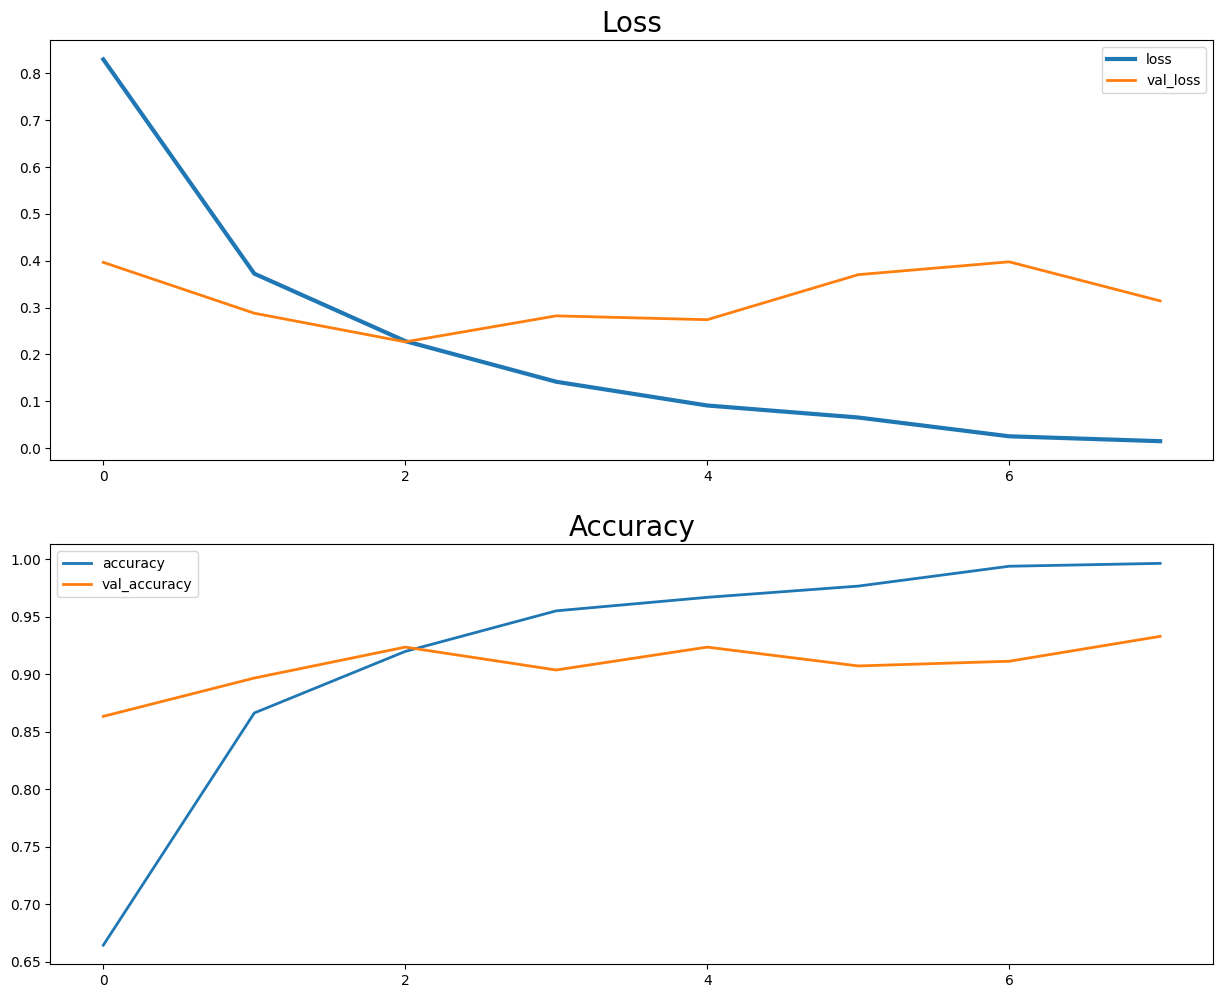

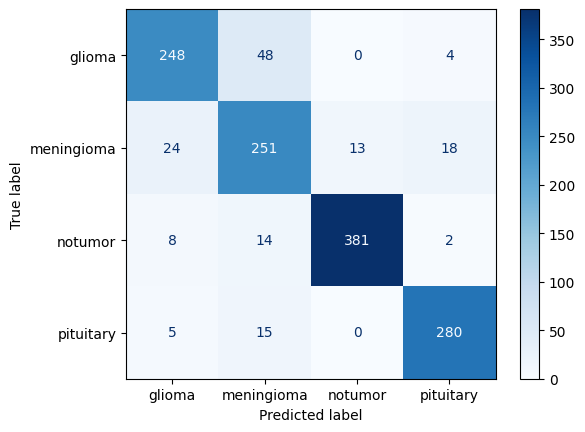

Classification Report
              precision    recall  f1-score   support

           0    0.87018   0.82667   0.84786       300
           1    0.76524   0.82026   0.79180       306
           2    0.96701   0.94074   0.95369       405
           3    0.92105   0.93333   0.92715       300

    accuracy                        0.88482      1311
   macro avg    0.88087   0.88025   0.88013      1311
weighted avg    0.88724   0.88482   0.88561      1311



In [50]:
model_name = 'efficientnetv2b0_augmentation_trainable_last25'
input_shape = (224,224,3)

aug_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tl25, history_aug_b0_tl25, training_time = train(aug_b0_tl25, model_name, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tl25, test_loss, test_acc, test_f1score = plot(aug_b0_tl25, history_aug_b0_tl25, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 1.1697 - accuracy: 0.4992 - f1_score: 0.4963

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 12s 52ms/step - loss: 1.1697 - accuracy: 0.4992 - f1_score: 0.4963 - val_loss: 0.8499 - val_accuracy: 0.7167 - val_f1_score: 0.7077 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 4s 34ms/step - loss: 0.7989 - accuracy: 0.6833 - f1_score: 0.6722 - val_loss: 0.5996 - val_accuracy: 0.8032 - val_f1_score: 0.7938 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 4s 33ms/step - loss: 0.6361 - accuracy: 0.7585 - f1_score: 0.7507 - val_loss: 0.5090 - val_accuracy: 0.8271 - val_f1_score: 0.8203 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 4s 33ms/step - loss: 0.5431 - accuracy: 0.7920 - f1_score: 0.7855 - val_loss: 0.4550 - val_accuracy: 0.8400 - val_f1_score: 0.8277 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 4s 35ms/step - loss: 0.5017 - accuracy: 0.8077 - f1_score: 0.8020 - val_loss: 0.4177 - val_accuracy: 0.8528 - val_f1_score: 0.8442 - lr: 1.0000e-04


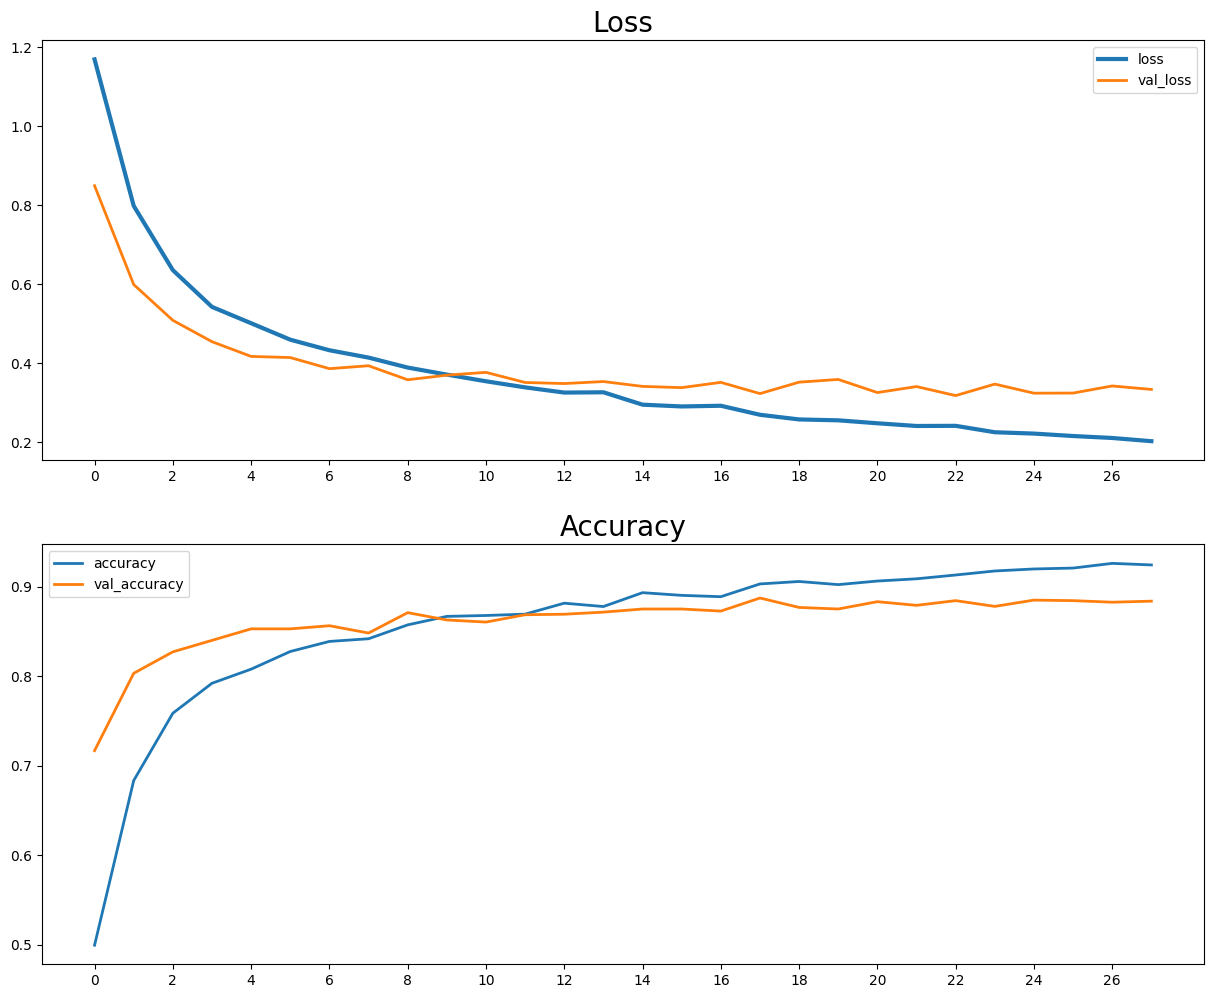

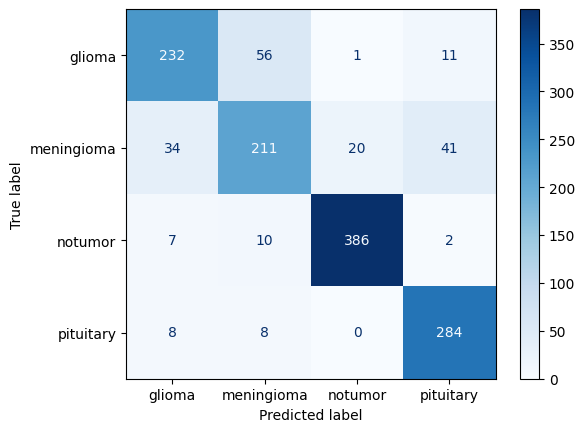

Classification Report
              precision    recall  f1-score   support

           0    0.82562   0.77333   0.79862       300
           1    0.74035   0.68954   0.71404       306
           2    0.94840   0.95309   0.95074       405
           3    0.84024   0.94667   0.89028       300

    accuracy                        0.84897      1311
   macro avg    0.83865   0.84066   0.83842      1311
weighted avg    0.84699   0.84897   0.84685      1311



In [51]:
model_name = 'efficientnetv2b0_augmentation_not_trainable'
input_shape = (224,224,3)

aug_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_nt, history_aug_b0_nt, training_time = train(aug_b0_nt, model_name, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_nt, test_loss, test_acc, test_f1score = plot(aug_b0_nt, history_aug_b0_nt, test_ds_224)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

### EfficientNetV2B3

#### trainable first25

Epoch 1/30


2024-10-27 15:27:14.497723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


166/166 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.7641 - f1_score: 0.7548

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 69s 135ms/step - loss: 0.6087 - accuracy: 0.7641 - f1_score: 0.7548 - val_loss: 0.2895 - val_accuracy: 0.8981 - val_f1_score: 0.8916 - lr: 1.0000e-04
Epoch 2/30
166/166 [==============================] - 17s 105ms/step - loss: 0.2466 - accuracy: 0.9139 - f1_score: 0.9118 - val_loss: 0.1227 - val_accuracy: 0.9554 - val_f1_score: 0.9532 - lr: 1.0000e-04
Epoch 3/30
166/166 [==============================] - 19s 117ms/step - loss: 0.1251 - accuracy: 0.9596 - f1_score: 0.9587 - val_loss: 0.1152 - val_accuracy: 0.9624 - val_f1_score: 0.9612 - lr: 1.0000e-04
Epoch 4/30
166/166 [==============================] - 16s 99ms/step - loss: 0.0593 - accuracy: 0.9812 - f1_score: 0.9808 - val_loss: 0.1286 - val_accuracy: 0.9554 - val_f1_score: 0.9534 - lr: 1.0000e-04
Epoch 5/30
166/166 [==============================] - 17s 105ms/step - loss: 0.0432 - accuracy: 0.9864 - f1_score: 0.9862 - val_loss: 0.1054 - val_accuracy: 0.9699 - val_f1_score: 0.9691 - lr: 1.0

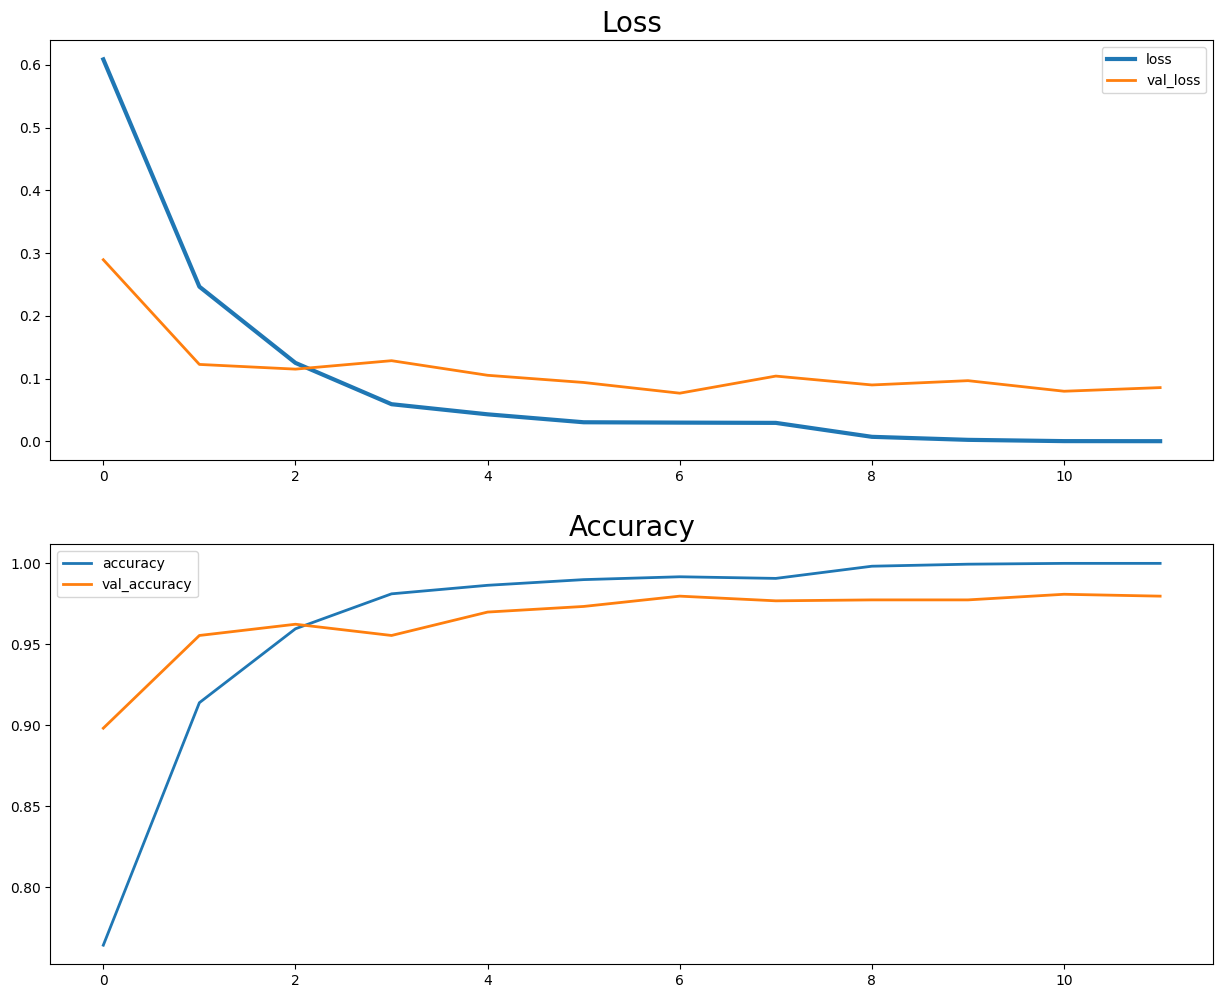

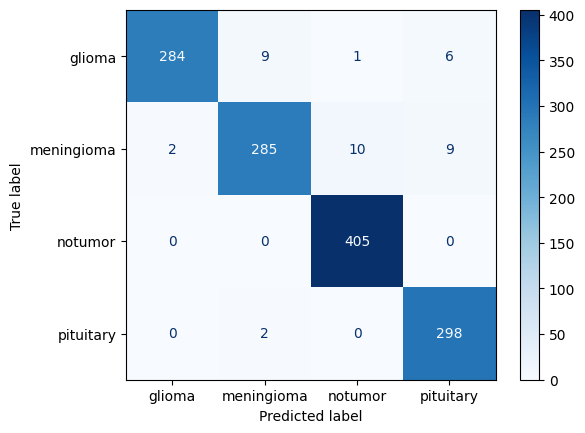

Classification Report
              precision    recall  f1-score   support

           0    0.99301   0.94667   0.96928       300
           1    0.96284   0.93137   0.94684       306
           2    0.97356   1.00000   0.98660       405
           3    0.95208   0.99333   0.97227       300

    accuracy                        0.97025      1311
   macro avg    0.97037   0.96784   0.96875      1311
weighted avg    0.97059   0.97025   0.97008      1311



In [52]:
model_name = 'efficientnetv2b3_augmentation_trainable_first25'
input_shape = (300,300,3)

aug_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tf25, history_aug_b3_tf25, training_time = train(aug_b3_tf25, model_name, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tf25, test_loss, test_acc, test_f1score = plot(aug_b3_tf25, history_aug_b3_tf25, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 15:31:40.036636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


165/166 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.7301 - f1_score: 0.7233

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 32s 83ms/step - loss: 0.6716 - accuracy: 0.7307 - f1_score: 0.7241 - val_loss: 0.2589 - val_accuracy: 0.9138 - val_f1_score: 0.9071 - lr: 1.0000e-04
Epoch 2/30
166/166 [==============================] - 11s 64ms/step - loss: 0.2368 - accuracy: 0.9184 - f1_score: 0.9163 - val_loss: 0.2143 - val_accuracy: 0.9253 - val_f1_score: 0.9174 - lr: 1.0000e-04
Epoch 3/30
166/166 [==============================] - 10s 61ms/step - loss: 0.1203 - accuracy: 0.9553 - f1_score: 0.9539 - val_loss: 0.1628 - val_accuracy: 0.9450 - val_f1_score: 0.9420 - lr: 1.0000e-04
Epoch 4/30
166/166 [==============================] - 9s 54ms/step - loss: 0.0609 - accuracy: 0.9792 - f1_score: 0.9785 - val_loss: 0.2322 - val_accuracy: 0.9340 - val_f1_score: 0.9304 - lr: 1.0000e-04
Epoch 5/30
166/166 [==============================] - 10s 60ms/step - loss: 0.0325 - accuracy: 0.9900 - f1_score: 0.9898 - val_loss: 0.2388 - val_accuracy: 0.9473 - val_f1_score: 0.9437 - lr: 1.0000e-

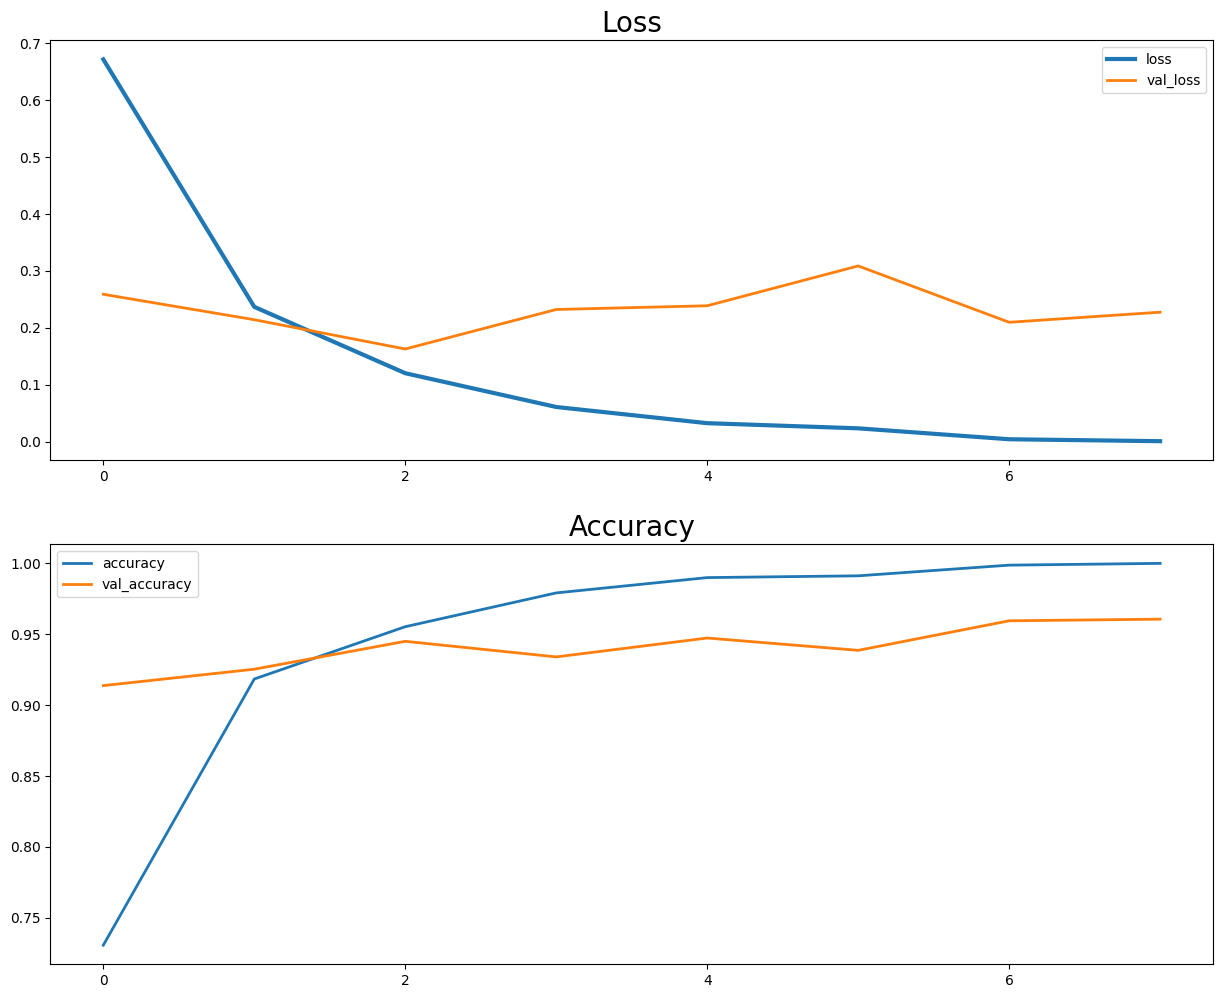

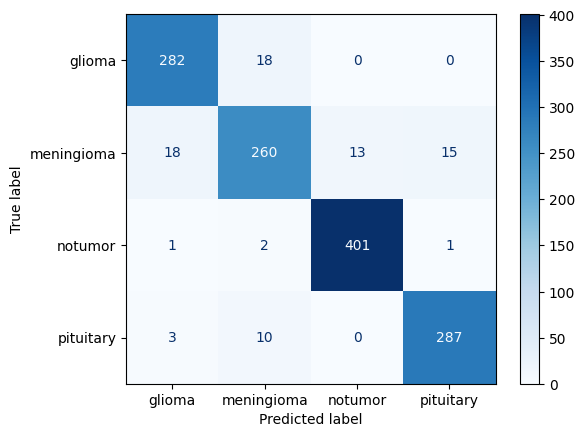

Classification Report
              precision    recall  f1-score   support

           0    0.92763   0.94000   0.93377       300
           1    0.89655   0.84967   0.87248       306
           2    0.96860   0.99012   0.97924       405
           3    0.94719   0.95667   0.95191       300

    accuracy                        0.93822      1311
   macro avg    0.93499   0.93412   0.93435      1311
weighted avg    0.93751   0.93822   0.93766      1311



In [53]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (300,300,3)

aug_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tl25, history_aug_b3_tl25, training_time = train(aug_b3_tl25, model_name, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tl25, test_loss, test_acc, test_f1score = plot(aug_b3_tl25, history_aug_b3_tl25, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

Epoch 1/30
165/166 [============================>.] - ETA: 0s - loss: 1.0329 - accuracy: 0.5740 - f1_score: 0.5640

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 19s 64ms/step - loss: 1.0311 - accuracy: 0.5748 - f1_score: 0.5648 - val_loss: 0.6563 - val_accuracy: 0.8079 - val_f1_score: 0.7965 - lr: 1.0000e-04
Epoch 2/30
166/166 [==============================] - 7s 44ms/step - loss: 0.6667 - accuracy: 0.7487 - f1_score: 0.7416 - val_loss: 0.5070 - val_accuracy: 0.8252 - val_f1_score: 0.8217 - lr: 1.0000e-04
Epoch 3/30
166/166 [==============================] - 7s 42ms/step - loss: 0.5502 - accuracy: 0.7899 - f1_score: 0.7836 - val_loss: 0.4550 - val_accuracy: 0.8374 - val_f1_score: 0.8310 - lr: 1.0000e-04
Epoch 4/30
166/166 [==============================] - 7s 44ms/step - loss: 0.4781 - accuracy: 0.8193 - f1_score: 0.8145 - val_loss: 0.3875 - val_accuracy: 0.8588 - val_f1_score: 0.8507 - lr: 1.0000e-04
Epoch 5/30
166/166 [==============================] - 7s 45ms/step - loss: 0.4465 - accuracy: 0.8348 - f1_score: 0.8303 - val_loss: 0.3735 - val_accuracy: 0.8686 - val_f1_score: 0.8634 - lr: 1.0000e-04


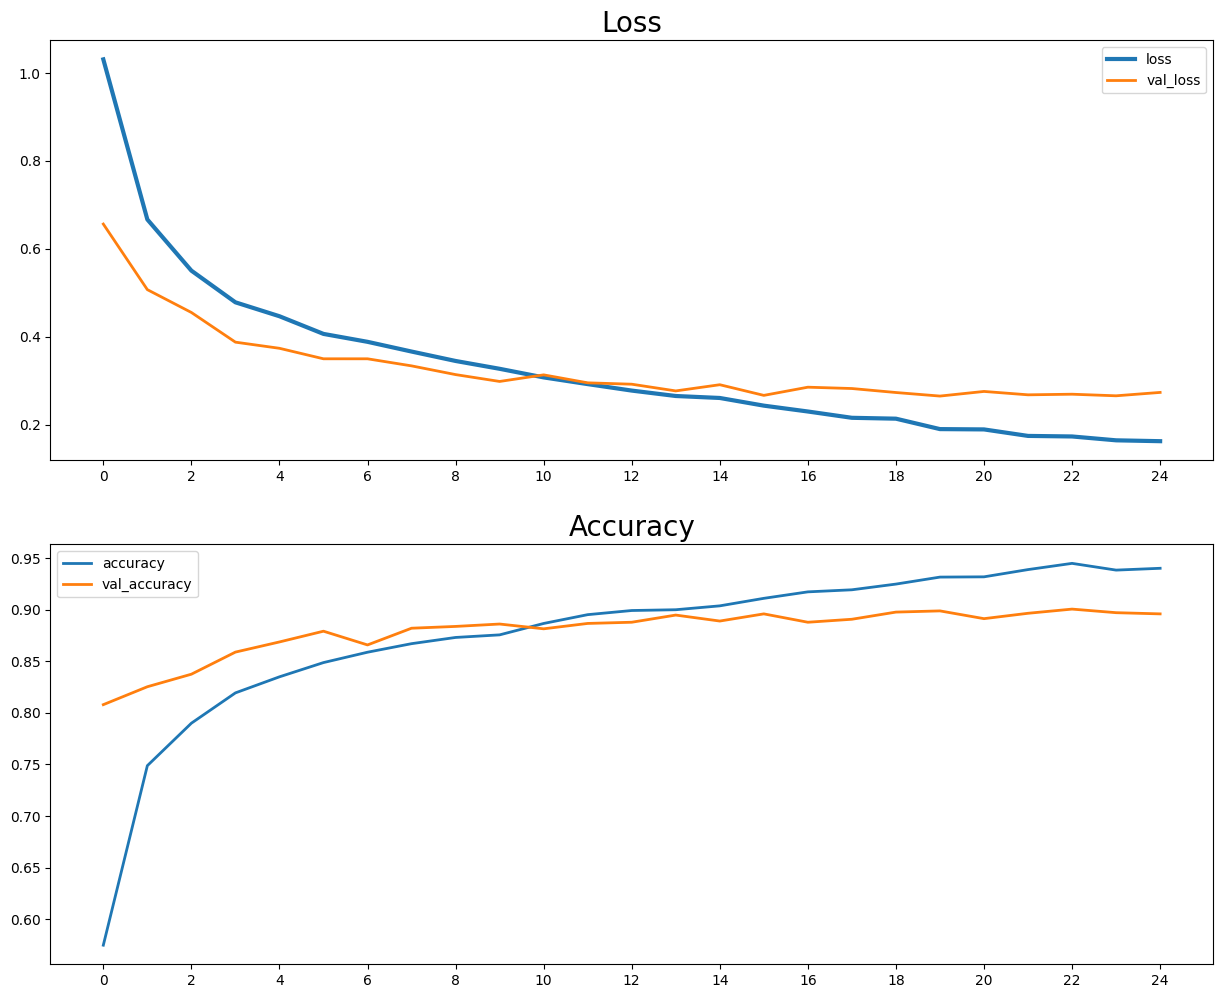

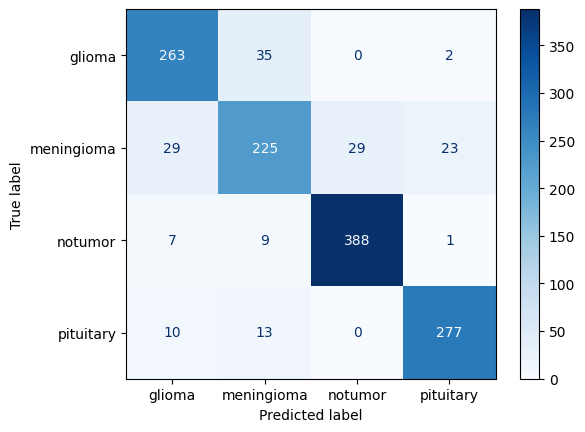

Classification Report
              precision    recall  f1-score   support

           0    0.85113   0.87667   0.86371       300
           1    0.79787   0.73529   0.76531       306
           2    0.93046   0.95802   0.94404       405
           3    0.91419   0.92333   0.91874       300

    accuracy                        0.87948      1311
   macro avg    0.87341   0.87333   0.87295      1311
weighted avg    0.87764   0.87948   0.87815      1311



In [54]:
model_name = 'efficientnetv2b3_augmentation_not_trainable'
input_shape = (300,300,3)
aug_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_nt, history_aug_b3_nt, training_time = train(aug_b3_nt, model_name, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_nt, test_loss, test_acc, test_f1score = plot(aug_b3_nt, history_aug_b3_nt, test_ds_300)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

### EfficientNetV2M

#### trainable first25

Epoch 1/30


2024-10-27 15:37:23.780750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-27 15:37:38.964815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:12085: Filling up shuffle buffer (this may take a while): 462 of 1000
2024-10-27 15:37:39.130769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


499/499 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.5544 - f1_score: 0.5374

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 168s 168ms/step - loss: 0.9565 - accuracy: 0.5544 - f1_score: 0.5374 - val_loss: 0.3747 - val_accuracy: 0.8616 - val_f1_score: 0.8526 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 79s 158ms/step - loss: 0.3839 - accuracy: 0.8610 - f1_score: 0.8581 - val_loss: 0.2808 - val_accuracy: 0.9029 - val_f1_score: 0.8931 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 78s 157ms/step - loss: 0.1807 - accuracy: 0.9429 - f1_score: 0.9416 - val_loss: 0.1407 - val_accuracy: 0.9558 - val_f1_score: 0.9539 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 77s 155ms/step - loss: 0.1289 - accuracy: 0.9597 - f1_score: 0.9589 - val_loss: 0.1295 - val_accuracy: 0.9576 - val_f1_score: 0.9558 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 75s 150ms/step - loss: 0.1027 - accuracy: 0.9672 - f1_score: 0.9666 - val_loss: 0.1908 - val_accuracy: 0.9448 - val_f1_score: 0.9444 - lr: 1

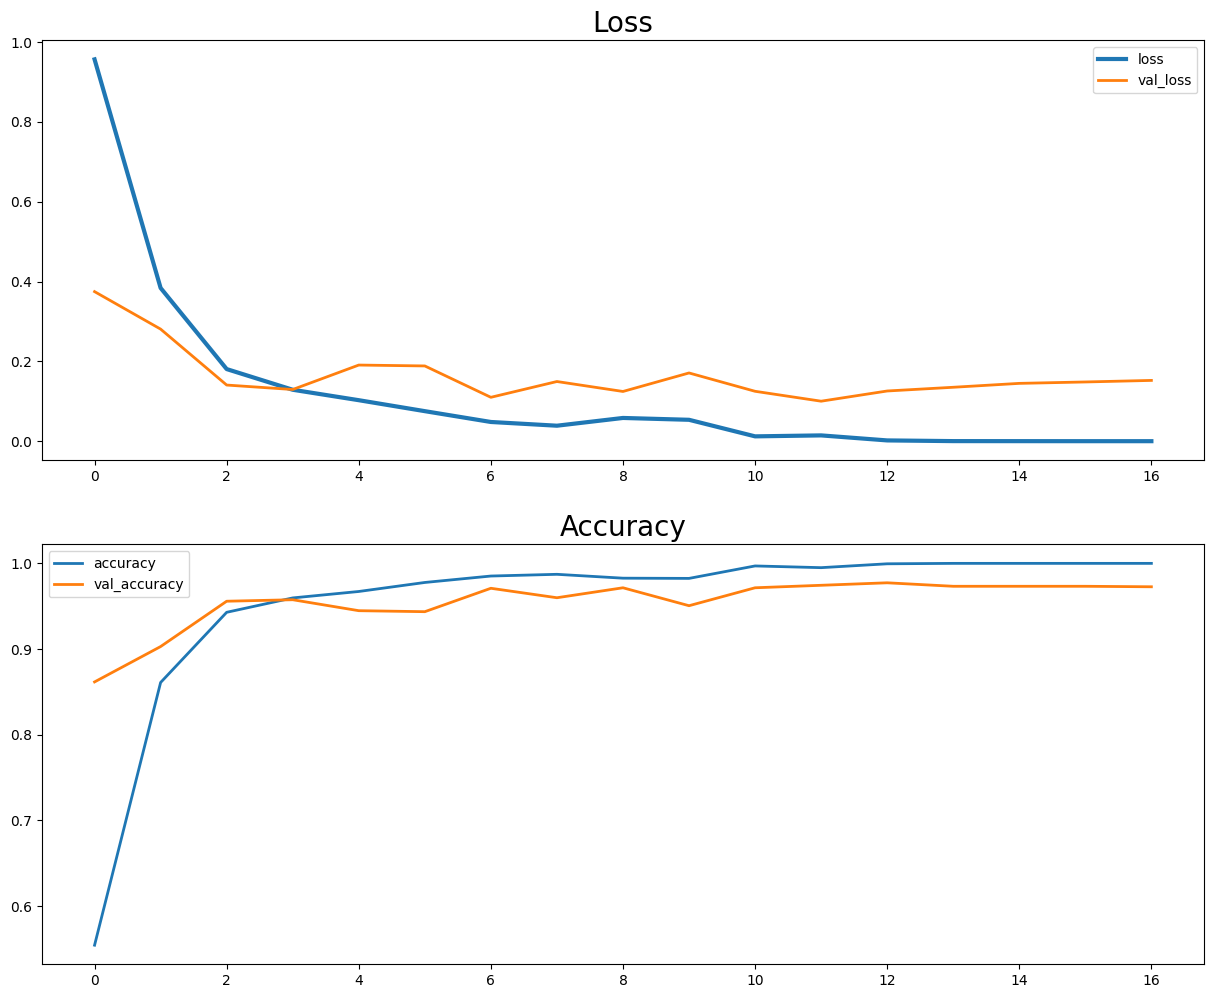

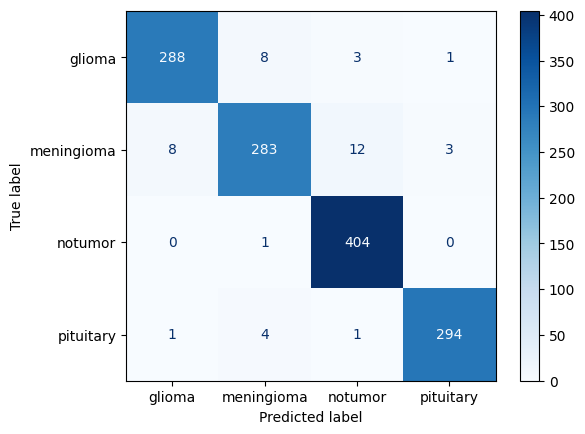

Classification Report
              precision    recall  f1-score   support

           0    0.96970   0.96000   0.96482       300
           1    0.95608   0.92484   0.94020       306
           2    0.96190   0.99753   0.97939       405
           3    0.98658   0.98000   0.98328       300

    accuracy                        0.96796      1311
   macro avg    0.96856   0.96559   0.96692      1311
weighted avg    0.96797   0.96796   0.96780      1311



In [55]:
model_name = 'efficientnetv2m_augmentation_trainable_first25'
input_shape = (380,380,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tf25, history_aug_m_tf25, training_time = train(aug_m_tf25, model_name, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tf25, test_loss, test_acc, test_f1score = plot(aug_m_tf25, history_aug_m_tf25, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### trainable last25

Epoch 1/30


2024-10-27 16:00:53.944368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7878 - f1_score: 0.7832

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 90s 114ms/step - loss: 0.5567 - accuracy: 0.7878 - f1_score: 0.7832 - val_loss: 0.2389 - val_accuracy: 0.9267 - val_f1_score: 0.9229 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 49s 98ms/step - loss: 0.2218 - accuracy: 0.9228 - f1_score: 0.9205 - val_loss: 0.2076 - val_accuracy: 0.9366 - val_f1_score: 0.9330 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 48s 96ms/step - loss: 0.1265 - accuracy: 0.9599 - f1_score: 0.9586 - val_loss: 0.1371 - val_accuracy: 0.9529 - val_f1_score: 0.9504 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 45s 91ms/step - loss: 0.1030 - accuracy: 0.9702 - f1_score: 0.9695 - val_loss: 0.2477 - val_accuracy: 0.9163 - val_f1_score: 0.9131 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 44s 89ms/step - loss: 0.0903 - accuracy: 0.9739 - f1_score: 0.9735 - val_loss: 0.2083 - val_accuracy: 0.9459 - val_f1_score: 0.9412 - lr: 1.0000

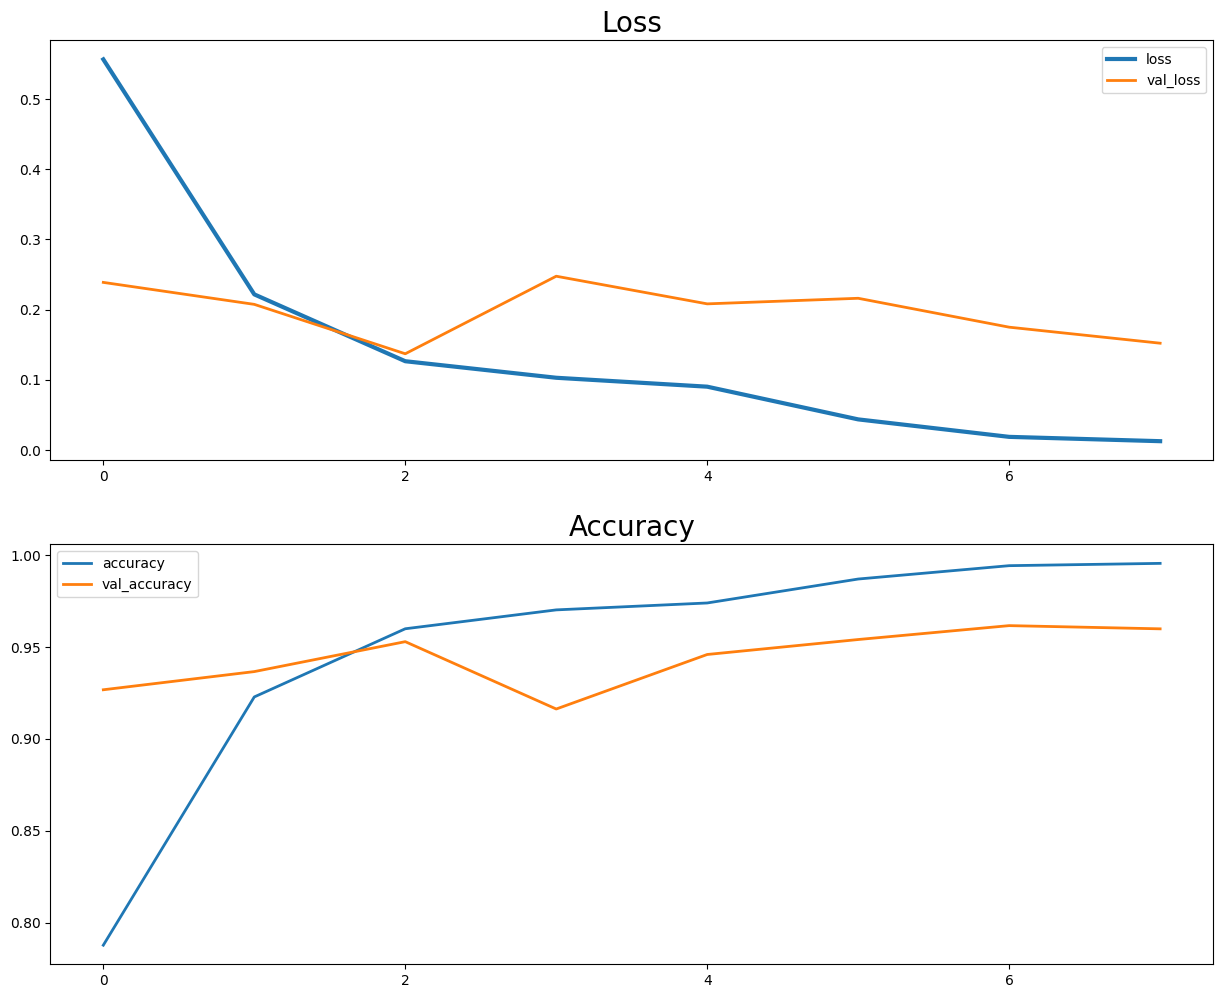

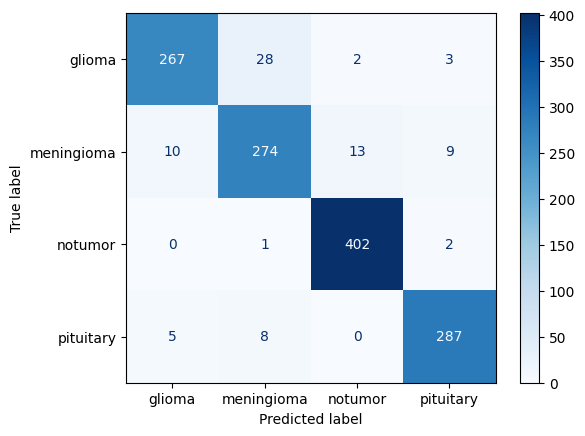

Classification Report
              precision    recall  f1-score   support

           0    0.94681   0.89000   0.91753       300
           1    0.88103   0.89542   0.88817       306
           2    0.96403   0.99259   0.97810       405
           3    0.95349   0.95667   0.95507       300

    accuracy                        0.93822      1311
   macro avg    0.93634   0.93367   0.93472      1311
weighted avg    0.93830   0.93822   0.93798      1311



In [56]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (380,380,3)

aug_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tl25, history_aug_m_tl25, training_time = train(aug_m_tl25, model_name, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tl25, test_loss, test_acc, test_f1score = plot(aug_m_tl25, history_aug_m_tl25, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

#### not trainable

Epoch 1/30
498/499 [============================>.] - ETA: 0s - loss: 1.0114 - accuracy: 0.5766 - f1_score: 0.5709

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 55s 71ms/step - loss: 1.0110 - accuracy: 0.5769 - f1_score: 0.5713 - val_loss: 0.7168 - val_accuracy: 0.7064 - val_f1_score: 0.6683 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 30s 60ms/step - loss: 0.7035 - accuracy: 0.7124 - f1_score: 0.7031 - val_loss: 0.5663 - val_accuracy: 0.7878 - val_f1_score: 0.7710 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 29s 59ms/step - loss: 0.5921 - accuracy: 0.7743 - f1_score: 0.7668 - val_loss: 0.4964 - val_accuracy: 0.8070 - val_f1_score: 0.7944 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 29s 59ms/step - loss: 0.5296 - accuracy: 0.7951 - f1_score: 0.7893 - val_loss: 0.4574 - val_accuracy: 0.8180 - val_f1_score: 0.8005 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 30s 61ms/step - loss: 0.4880 - accuracy: 0.8146 - f1_score: 0.8092 - val_loss: 0.4251 - val_accuracy: 0.8407 - val_f1_score: 0.8268 - lr: 1.0000e

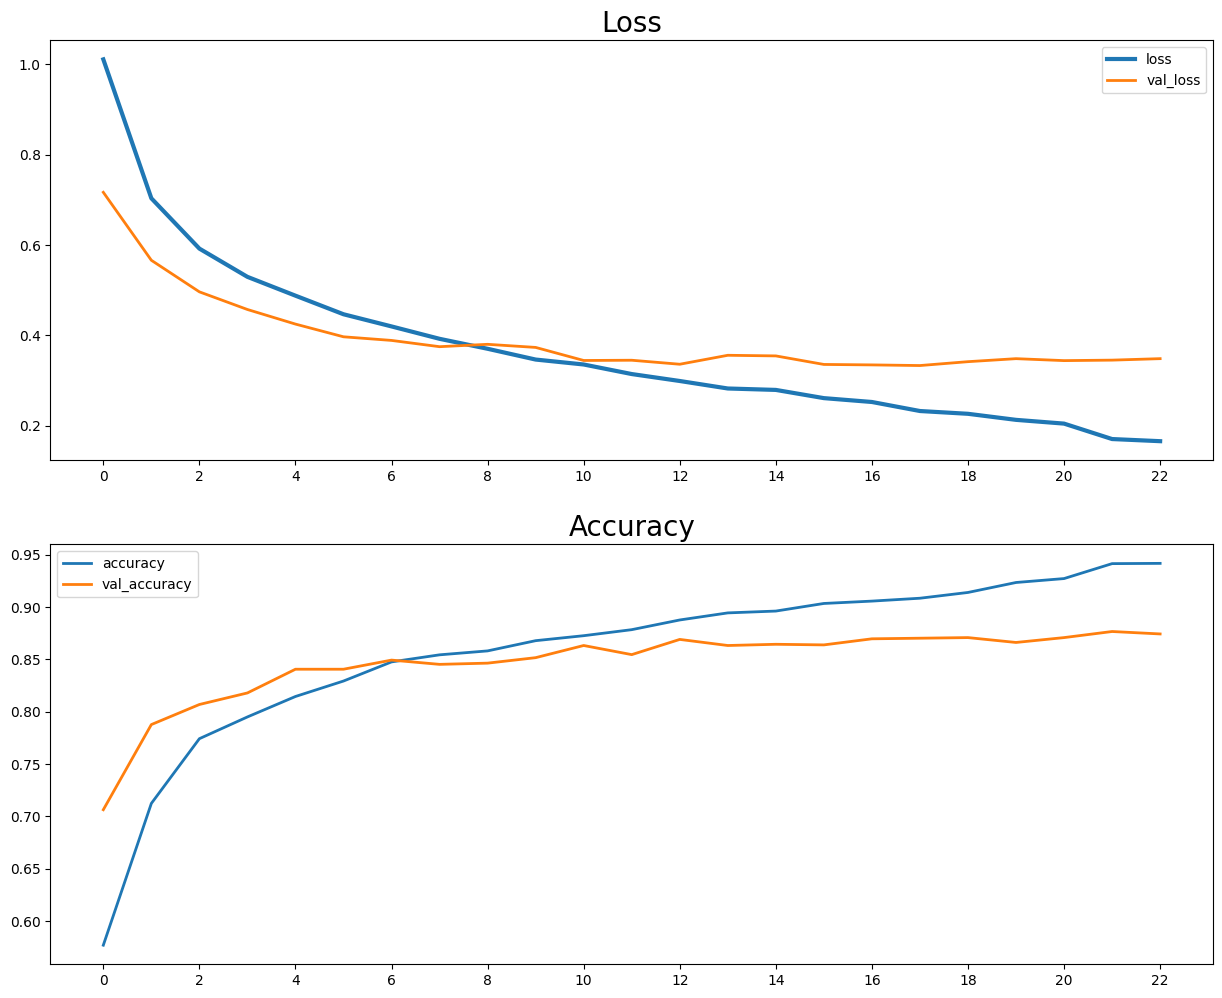

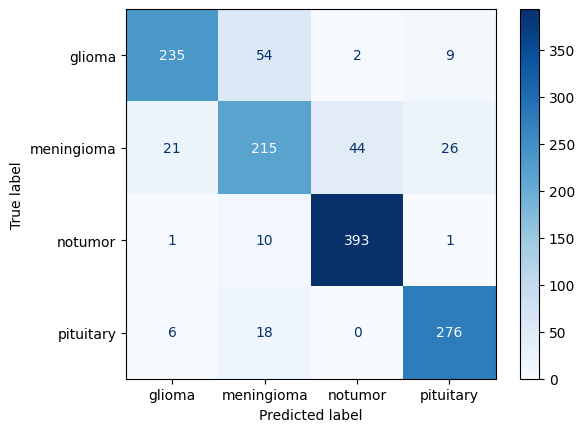

Classification Report
              precision    recall  f1-score   support

           0    0.89354   0.78333   0.83481       300
           1    0.72391   0.70261   0.71310       306
           2    0.89522   0.97037   0.93128       405
           3    0.88462   0.92000   0.90196       300

    accuracy                        0.85355      1311
   macro avg    0.84932   0.84408   0.84529      1311
weighted avg    0.85242   0.85355   0.85157      1311



In [57]:
model_name = 'efficientnetv2m_augmentation_not_trainable'
input_shape = (380,380,3)

aug_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_nt, history_aug_m_nt, training_time = train(aug_m_nt, model_name, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)
history_aug_m_nt, test_loss, test_acc, test_f1score = plot(aug_m_nt, history_aug_m_nt, test_ds_380)
result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time)

# Result

In [58]:
results = pd.DataFrame(result_dict)

print(results)

                                         Model Name  Test Loss  Test Accuracy  \
0       efficientnetv2b0_standart_trainable_first25   0.101441       0.981693   
1       efficientnetv2b0_standart_trainable_first25   0.058755       0.983982   
2        efficientnetv2b0_standart_trainable_last25   0.187146       0.955759   
3           efficientnetv2b0_standart_not_trainable   0.167665       0.943555   
4       efficientnetv2b3_standart_trainable_first25   0.033940       0.990847   
5        efficientnetv2b3_standart_trainable_last25   0.080933       0.984744   
6           efficientnetv2b3_standart_not_trainable   0.144520       0.948894   
7        efficientnetv2m_standart_trainable_first25   0.048929       0.990084   
8         efficientnetv2m_standart_trainable_last25   0.060847       0.980168   
9            efficientnetv2m_standart_not_trainable   0.197347       0.938215   
10  efficientnetv2b0_augmentation_trainable_first25   0.117343       0.967963   
11   efficientnetv2b0_augmen

In [59]:
results.to_csv("result.csv", index=False)

df = pd.read_csv("result.csv")

print(df)

                                         Model Name  Test Loss  Test Accuracy  \
0       efficientnetv2b0_standart_trainable_first25   0.101441       0.981693   
1       efficientnetv2b0_standart_trainable_first25   0.058755       0.983982   
2        efficientnetv2b0_standart_trainable_last25   0.187146       0.955759   
3           efficientnetv2b0_standart_not_trainable   0.167665       0.943555   
4       efficientnetv2b3_standart_trainable_first25   0.033940       0.990847   
5        efficientnetv2b3_standart_trainable_last25   0.080933       0.984744   
6           efficientnetv2b3_standart_not_trainable   0.144520       0.948894   
7        efficientnetv2m_standart_trainable_first25   0.048929       0.990084   
8         efficientnetv2m_standart_trainable_last25   0.060847       0.980168   
9            efficientnetv2m_standart_not_trainable   0.197347       0.938215   
10  efficientnetv2b0_augmentation_trainable_first25   0.117343       0.967963   
11   efficientnetv2b0_augmen

# Testing using Different Dataset

In [60]:
def evaluate_model_on_dataset(model, dataset, class_names):
    # y_true = []
    # y_pred = []

    # test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)
    
    # # Iterate over the dataset
    # for images, labels in dataset:
    #     # Get true labels
    #     y_true.extend(np.argmax(labels.numpy(), axis=1))
        
    #     # Predict using the model
    #     predictions = model.predict(images)
    #     y_pred.extend(np.argmax(predictions, axis=1))
    
    # # Ensure y_true and y_pred have the same length
    # assert len(y_true) == len(y_pred), f"Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}"
    
    # # Generate confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    
    # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    # # Generate classification report
    # report = classification_report(y_true, y_pred, target_names=class_names)
    # print(f"Classification Report:\n{report}")




    class_names = sorted(class_names)

    model.evaluate(dataset)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)
    
    return cm, cr

In [61]:
def load_new_dataset(dataset_dir, image_size=(224, 224), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',  # Assuming the dataset has multiple classes
        class_names=[class_name for class_name in os.listdir(dataset_dir)],
        seed=42,
        image_size=image_size,  # Automatically resizes images to 224x224
        batch_size=batch_size,
        shuffle=False  # Turn off shuffle for evaluation
    )
    return dataset

In [62]:
def load_best_model(model_path):
    return tf.keras.models.load_model(model_path)

Found 3057 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step


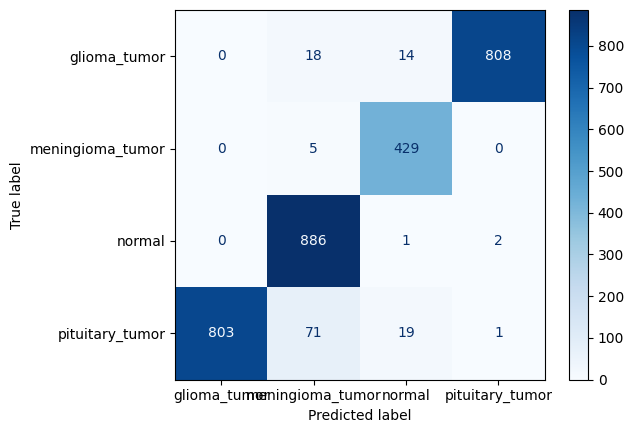

Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       840
           1    0.00510   0.01152   0.00707       434
           2    0.00216   0.00112   0.00148       889
           3    0.00123   0.00112   0.00117       894

    accuracy                        0.00229      3057
   macro avg    0.00212   0.00344   0.00243      3057
weighted avg    0.00171   0.00229   0.00178      3057



(array([[  0,  18,  14, 808],
        [  0,   5, 429,   0],
        [  0, 886,   1,   2],
        [803,  71,  19,   1]]),
 '              precision    recall  f1-score   support\n\n           0    0.00000   0.00000   0.00000       840\n           1    0.00510   0.01152   0.00707       434\n           2    0.00216   0.00112   0.00148       889\n           3    0.00123   0.00112   0.00117       894\n\n    accuracy                        0.00229      3057\n   macro avg    0.00212   0.00344   0.00243      3057\nweighted avg    0.00171   0.00229   0.00178      3057\n')

In [63]:
# 1. Load the best model (replace 'path_to_best_model.h5' with the actual model file path)
best_model = load_best_model(CWD+'/model/model_efficientnetv2b0_standart_trainable_first25.h5')

# 2. Load the new dataset (replace 'path_to_new_dataset' with the actual dataset directory)
new_dataset = load_new_dataset(CWD + '/dataset/test')

class_names = new_dataset.class_names

# 4. Evaluate the model and generate confusion matrix and classification report
evaluate_model_on_dataset(best_model, new_dataset, class_names)

# Try

In [67]:
def build_model(base_model, train_ds, valid_ds, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False


    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    # checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Model training
    history = model.fit(
        train_ds,
        epochs=20,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Fine Tuning

    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    history = model.fit(
        train_ds,
        epochs=15,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Results

    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds_224, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds_224:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return model, history, test_loss, test_acc, test_f1score

Epoch 1/20
125/125 [==============================] - 11s 41ms/step - loss: 0.5516 - accuracy: 0.7797 - f1_score: 0.7723 - val_loss: 0.3370 - val_accuracy: 0.8686 - val_f1_score: 0.8656 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 4s 30ms/step - loss: 0.3449 - accuracy: 0.8715 - f1_score: 0.8677 - val_loss: 0.2391 - val_accuracy: 0.9089 - val_f1_score: 0.9037 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2944 - accuracy: 0.8915 - f1_score: 0.8886 - val_loss: 0.2138 - val_accuracy: 0.9194 - val_f1_score: 0.9161 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 4s 29ms/step - loss: 0.2511 - accuracy: 0.9030 - f1_score: 0.8999 - val_loss: 0.2144 - val_accuracy: 0.9182 - val_f1_score: 0.9141 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2261 - accuracy: 0.9112 - f1_score: 0.9081 - val_loss: 0.2002 - val_accuracy: 0.9229 - val_f1_score: 0.9168 - lr: 0.0010
Epoch 6/2

2024-10-27 16:30:48.694599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 42s 81ms/step - loss: 0.0491 - accuracy: 0.9845 - f1_score: 0.9839 - val_loss: 0.1328 - val_accuracy: 0.9609 - val_f1_score: 0.9585 - lr: 1.0000e-05
Epoch 2/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0438 - accuracy: 0.9855 - f1_score: 0.9851 - val_loss: 0.1226 - val_accuracy: 0.9632 - val_f1_score: 0.9611 - lr: 1.0000e-05
Epoch 3/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0415 - accuracy: 0.9840 - f1_score: 0.9835 - val_loss: 0.1187 - val_accuracy: 0.9614 - val_f1_score: 0.9594 - lr: 1.0000e-05
Epoch 4/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0276 - accuracy: 0.9905 - f1_score: 0.9902 - val_loss: 0.1117 - val_accuracy: 0.9679 - val_f1_score: 0.9660 - lr: 1.0000e-05
Epoch 5/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0295 - accuracy: 0.9912 - f1_score: 0.9909 - val_loss: 0.1163 - val_accuracy: 0.9702 - val_f1_score: 0.9680 - lr: 1.0000e

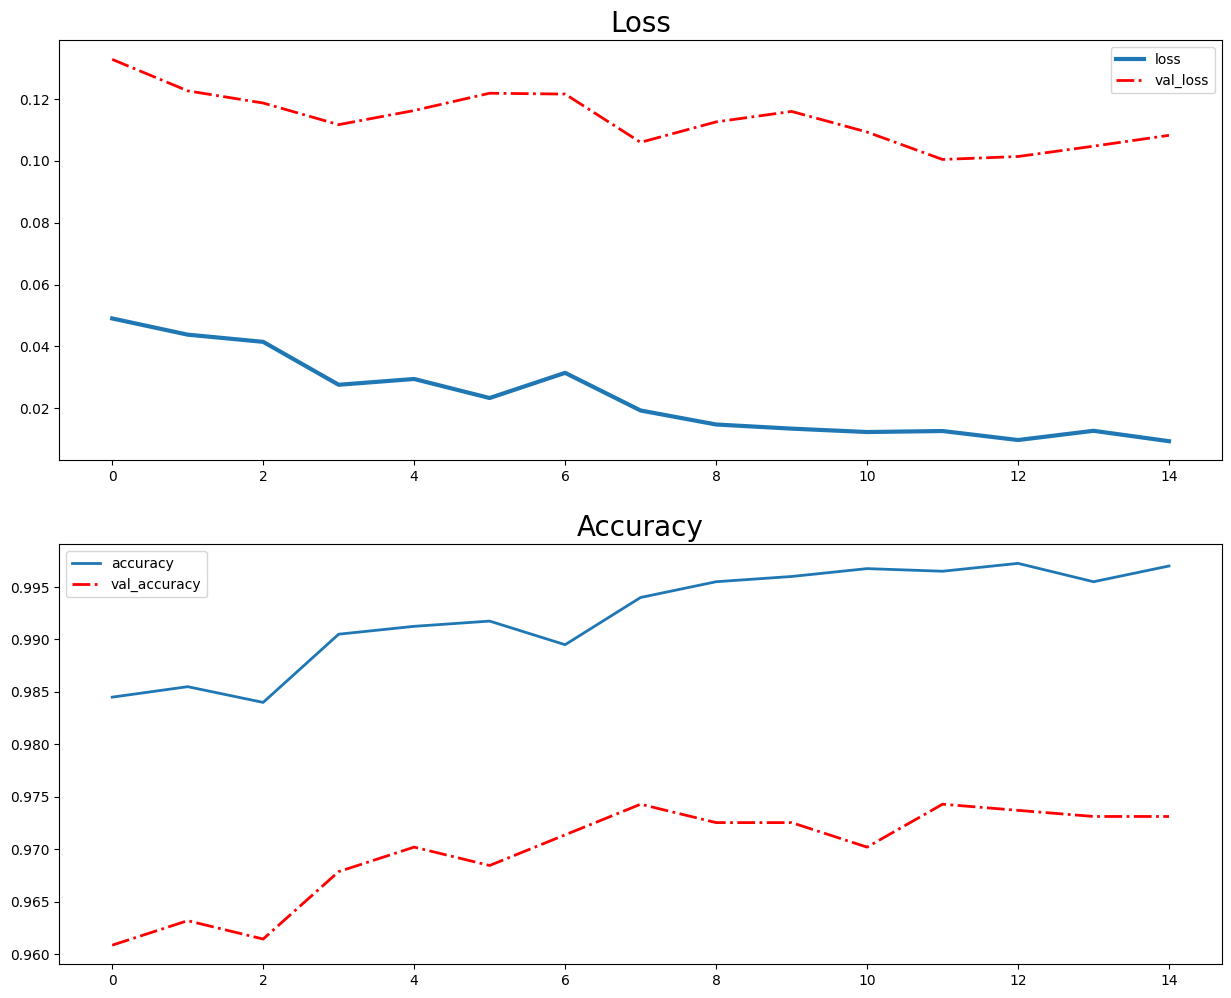

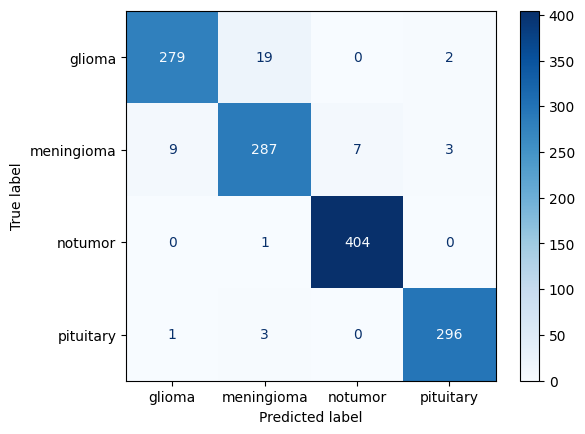

Classification Report
              precision    recall  f1-score   support

           0    0.96540   0.93000   0.94737       300
           1    0.92581   0.93791   0.93182       306
           2    0.98297   0.99753   0.99020       405
           3    0.98339   0.98667   0.98502       300

    accuracy                        0.96568      1311
   macro avg    0.96439   0.96303   0.96360      1311
weighted avg    0.96570   0.96568   0.96559      1311



In [68]:
model_name = 'test'
input_shape = (224,224,3)

model = build_model(EfficientNetV2B0, train_ds_224, valid_ds_224, input_shape=input_shape, num_classes=4)